# ZHAW Course VS.INS, Spring 2023
## Problem Set \#2: Data-driven Diagnostics for Deep Learning Prognostics

---

YOUR NAME HERE

---

**Due May 31st at 11:59 pm CTE**

**Notes:** 
- (1) If you have a question about this case study, I encourage you to post your question on our MS Teams Channel, VS.INS 2023. But you can also reach me by email at aria@zhaw.ch 
- (2) An introduction to the dataset used in this assignment (i.e., N-CMAPSS) and examples of the application of relevant data-driven models will be covered during the practical sessions. You can and should re-use the code covered during these practical sessions. 
- (3) You are encouraged to collaborate as much as you can/want, but you will need to submit your own solution.
- (4) I recommend that you type your answers in this notebook and submit it together with the corresponding pdf version (see File>Download as> PDF via Latex)
- (5) If you wish to submit on time, submit by email at aria@zhaw.ch before May 31st at 11:59 pm CET.

# Introduction

In this case study, you are asked to address the problem of remaining useful lifetime ($\textit{RUL}$) prediction in complex engineered systems from condition monitoring (CM) data. A baseline data-driven prognostics model based on a feedforward neural network is provided in this Jupyter notebook. You will then focus on alternative solution strategies involving the use of diagnostics information to solve the prognostics problem.

All the methods and code required to solve this exercise have been or will be covered during the lectures and practical sessions (WK10, WK11, WK12 and WK13), e.g., the feedforward neural network (NN) will be coved in full detail in week 13. So your task is to solve the corresponding problems by reusing as much as possible the code covered during the practical sessions. 

The case study makes use of the **new** C-MAPSS (Commercial Modular Aero-Propulsion System Simulation) dataset from NASA for aircraft engines. The dataset was generated by the ETHZ IMS chair with the C-MAPSS dynamical model in the context of a collaboration with NASA Ames. More details about the generation process can be found at https://www.mdpi.com/2306-5729/6/1/5.

Since you might not yet be familiar with the prognostic problem, the new C-MAPSS dataset, and diagnostics solution strategies, this Jupyter notebook includes extensive descriptions.

## Problem formulation
Given are multivariate time series of sensor readings $x_{s_i} = [x_{s_i}^{(1)}, \dots, x_{s_i}^{(m_i)}]^T$ and their corresponding RUL, i.e., $y_i=[y_i^{1},\dots, y_i^{m_i}]^T$, from a fleet of $N$ units ($i=1, \dots, N$). Each observation $x_{s_i}^{(t)} \in R^{p}$ is a vector of $p$ raw measurements taken under operating conditions $w_i^{(t)} \in R^{s}$. The length of the sensory signal for the $\textit{i-th}$ unit is given by $m_{i}$, which can, in general, differ from unit to unit. The total combined length of the available dataset is $m={\sum_{i=1}^{N}m_i}$. More compactly, we denote the available develpment dataset as $\mathcal{D} =\{w_i, x_{s_i}, y_i\}_{i=1}^{N}$. We also refer as condition monitoring (CM) data to the set of observed varaibles $\{w_i, x_{s_i}\}_{i=1}^{N}$. 

In addition to the condition monitoring (CM) data, i.e., $\{w_i, x_{s_i}\}_{i=1}^{N}$, and the RUL label, i.e., $\{y_i\}_{i=1}^{N}$, you have access to a performance gap model parameters $\theta_i^{(t)} \in R^{d}$ indicating the evaluated performance gap on $d$ system's components to a reference (i.e., healthy) engine for the development units.  Starting from an unknown initial health condition, the CM data of each unit records the degradation process of the system's components. The system's components experience $\textit{normal}$ (linear) degradation until point in time $t_{s_i}$, when an $\text{abnormal}$ (exponential) condition arises, leading to an eventual failure at $t_{\text{EOL}_i}$ (end-of-life).

Given this setup, the task is to obtain a predictive model $\mathcal{G}$ that provides a reliable RUL estimate ($\mathbf{\hat{y}}$) on a test dataset of $M$ units $\mathcal{D}_{T*}=\{w_{j*}, x_{s_j*}\}_{j=1}^{M}$, where $x_{s_j*} = [x_{s_j*}^{1},\dots, x_{s_j*}^{k_j}]$ are multivariate time series of sensor readings taken under operating conditions $w_{j*}^{(t)}$. The total combined length of the test dataset is $m_*={\sum_{j=1}^{M}k_j}$

## Baseline solution strategy

Since we have a dataset of input and output variables i.e., $\mathcal{D} =\{x_i, y_i\}_{i=1}^{N}$ with $x_i= [w_i, x_{s_i}] \in R^n$, we followed a standard supervised learning approach aiming to learn a mapping function from the CM signals to the RUL target $\mathbf{y}$ (i.e., $\mathcal{G}: \mathbf{x} \longmapsto \mathbf{y}$). Once we discover an optimal mapping $\mathcal{G}$, we used it to predict RUL on the test dataset $\mathcal{D}_{T*}$.

##  Dataset: N-CMAPSS DS02_v0

This case study makes use of a synthetic dataset with run-to-failure degradation trajectories of a small fleet comprising nine turbofan engines with unknown and different initial health conditions. The dataset was generated with the Commercial Modular Aero-Propulsion System Simulation (CMAPSS) model. Real flight conditions, as recorded on board commercial jets, were taken as input to the CMAPSS model. The dataset contains $N=6$ development units ($u=$ 2, 5, 10, 16, 18 \& 20) and $M=3$ test units ($u=$ 11, 14 \& 15).  

Two distinctive failure modes are present in the available dataset ($\mathcal{D}$). Units 2, 5, and 10 have failure modes of an $\textit{abnormal}$ high-pressure turbine (HPT) efficiency degradation. Units 16, 18, and 20 are subject to a more complex failure mode that affects the low-pressure turbine (LPT) efficiency and flow in combination with the high-pressure turbine (HPT) efficiency degradation. Test units are subjected to the same complex failure mode. The degradation of the affected system components follows a stochastic process with a linear $\textit{normal degradation}$ followed by a steeper $\textit{abnormal degradation}$. The degradation rate of each component varies within the fleet. The transition from $\textit{normal}$ to $\textit{abnormal}$ degradation is smooth and occurs at different cycle times for each unit. The transition time ($t_{s}$) is dependent on the operating conditions, i.e., flight and degradation profile. It should be noted that although the degradation profiles of individual components show nearly overlapping trajectories, the combined profile (i.e., the profile in three dimensions) is clearly different.

The sampling rate of the data is 0.1Hz, resulting in a total dataset size of 0.53M samples for model development and 0.12M samples for testing. It is worth noting that while test unit 14 is a short flight engine with the lowest amount of flight time (0.16M seconds), it has the largest number of flight cycles. More details about the generation process and a more recent version of this dataset (i.e., DS02) can be found in https://www.mdpi.com/2306-5729/6/1/5.

Tables below provide the name, description and units of each variable in the dataset. The variable symbol corresponds to the internal variable name in CMAPSS. The descriptions and units are reported as in the model documentation [1].

**Scenario descriptors (i.e Flight Data) - $[w]$**

| \# | Symbol | Description                    | Units       |
|----|--------|--------------------------------|-------------|
| 1  | alt    | Altitude                       | ft          |
| 2  | Mach   | Flight Mach number             | -           |
| 3  | TRA    | Throttle-resolver angle        | \%          |
| 4  | T2     | Total temperature at fan inlet | $^{\circ}$R |

**Sensor readings - $[x_s]$**

| \# | Symbol | Description                        | Units       |
|----|--------|------------------------------------|-------------|
| 1  | Wf     | Fuel flow                          | pps         |
| 2  | Nf     | Physical fan speed                 | rpm         |
| 3  | Nc     | Physical core speed                | rpm         |
| 4  | T24    | Total temperature at LPC outlet    | $^{\circ}$R |
| 5  | T30    | Total temperature at HPC outlet    | $^{\circ}$R |
| 6  | T40    | Total temperature at burner outlet | $^{\circ}$R |
| 7  | T48    | Total temperature at HPT outlet    | $^{\circ}$R |
| 8  | T50    | Total temperature at LPT outlet    | $^{\circ}$R |
| 9  | P15    | Total pressure in bypass-duct      | psia        |
| 10 | P2     | Total pressure at fan inlet        | psia        |
| 11 | P21    | Total pressure at fan outlet       | psia        |
| 12 | P24    | Total pressure at LPC outlet       | psia        |
| 13 | P30    | Total pressure at HPC outlet       | psia        |
| 14 | Ps30   | Static pressure at HPC outlet      | psia        |
| 15 | P40    | Total pressure at burner outlet    | psia        |
| 16 | P50    | Total pressure at LPT outlet       | psia        |

**Performance gap - $[\theta]$**

| \# | Symbol         | Description             | Units |
|----|----------------|-------------------------|-------|
| 1  | HPT\_eff\_mod  | HPT efficiency modifier | -     |
| 2  | LPT\_eff\_mod  | LPT efficiency modifier | -     |
| 3  | LPT\_flow\_mod | HPT flow modifier       | -     |

In addition to $w, x_s$ and $\theta$ the dataset also provides the variables $Unit$, $Cycle$ and $RUL$; which contains labels with the Unit name, cycle time and RUL (in cycles) for each sample time. 

The location of the CM data $[w, x_s]$within the turbofan engine, i.e., their topological dependency, is provided in the next section.

## C-MAPSS dynamical model
The C-MAPSS dynamical model is a high fidelity computer model for simulation of a realistic large commercial turbofan engine. Although most of the implementation details of the CMAPSS engine model are not publicly available, the user manual [1] and the documentation of the similar model C-MAPSS40k [2] provide some details about the software and control implementation. In brief, the CMAPSS engine model represents a generic, high-bypass, twin-spool commercial turbofan engine. The engine consists of six main components: fan, low-pressure compressor (LPC), high-pressure compressor (HPC), combustor or burner, high-pressure turbine (HPT), and low-pressure turbine (LPT). The HPC and HPT are connected through the core shaft or high-speed shaft; the fan, LPC, and LPT are all connected to the fan shaft or low-speed shaft [2]. In addition to these turbo-machinery components and the combustor, the engine has an inlet at the front, a nozzle at the rear, a bypass duct, a variable-sized inter-stage bleed valve, a set of variable-angle stator or guide vanes, and a number of cooling bleeds. A schematic of the engine is shown in the Figure below. The CMAPSS model includes two types of models: 1) a transient aero-thermodynamic engine model and 2) an engine controller that allows the engine to be operated over a wide range of thrust levels spanning the full spectrum of flight conditions.

$\textit{Aero-thermodynamic Engine Model}$. The aero-thermodynamic engine model is a physics-based, component-level model where each of the engine components is represented as an infinitesimally small volume [2]. The engine is then balanced by mass flow rate continuity through the components. The thermodynamic model uses traditional off-design performance modeling approaches, common in gas turbines, that resort to 'component maps' of the rotating components. Thereby, this modeling strategy captures the gross characteristics of each engine component. The engine thermodynamic model also includes an atmospheric model modeling covering the following flight condions: (i) altitudes from sea level to 40,000 ft, (ii) Mach numbers from 0 to 0.90, and (iii) sea-level temperatures from –60 to 103 $^{\circ}$F

$\textit{Engine Controller}$. The controller converts the throttle command from the pilot into thrust while providing safe operation. The controller has two main components: the power management and protection logic controllers. The power management controller determines an engine pressure ratio (EPR), which is the ratio of turbine exit pressure to inlet pressure (P50/P2), or fan speed (Nf) setpoint based on the PLA, altitude, Mach number, and ambient temperature that, when achieved, results in the desired linear thrust profile. Protection logic aims at providing safe and smooth thrust transitions between distant setpoints. Safe operation implies 1) the protection of physical components by preventing overstress and 2) the avoidance of operability limits (e.g., compressor surge, stall, combustor lean blow-out). This protection is achieved through the use of controller limits on physical variables including limits on the maximum fan speed (Nf), core speed (Nc), and burner pressure (Ps3). The control model resorts to common industry control theory and linear engine models.

<img src="images/cmapss.png" style="width:750px;height:550px;">

The resuting physics-based performance model provide estimations of observed system dynamics ($\hat{x}_s$) and non-observable properties ($x_v$) given some input operating conditions ($w$). This model also serve as structural causal models, relating the measured properties (i.e., $x_s$ and $w$) to the performance gap parameters $\theta$. The  resuting physics-based performance model involve a mathematical formulation of the physical principles governing the system dynamics in the form of differential algebraic equations (DAEs) or state-space representations:
 
\begin{align} 
  0 = F_s(\dot{x}_v, x_v, w,\theta) \\
  \hat{x}_s = F_x(\dot{x}_v, x_v, w,\theta)
\end{align}
    
where $F_s$ denotes the system dynamic state and $F_x$ the predicted system dynamics. 
    
The solution of the system dynamic state, by means of a root-finding algorithm, is handled internally so that from a user’s perspective, the model can be summarised with the following system equation:

\begin{align} 
  [\hat{x}_s, x_v] = F(w,\theta)
\end{align}

## Structure of the notebook

The notebook is divided in seven parts:

* Part 0 [10 points]: **Data exploration and visualization**

* Part 1 [10 points]: **Data pre-preprocessing**

* Part 2: **Build a baseline deep neural network**

* Part 3 [40 points]: **Build a diagnostics model**

* Part 4 [20 points]: **Build prognostics model with detection & dignostics features**

* Part 5 [20 points]: **Summary**

In [1]:
simSel = {'Part1': 1, 'Part2':1, 'Part3':1, 'Part4_a':1, 'Part4_b':1}

## Packages ##

Let's first import all the packages that you will need during this assignment.
- [h5py](http://www.h5py.org) is a common package to interact with a dataset that is stored on an H5 file.
- [numpy](www.numpy.org) is the fundamental package for scientific computing with Python.
- [pandas](https://pandas.pydata.org/) is a software library written for Python for data manipulation and analysis.
- [sklearn](http://scikit-learn.org/stable/) provides simple and efficient tools for data mining and data analysis. 
- [seaborn](https://seaborn.pydata.org/) is another famous library to plot graphs in Python.
- [matplotlib](http://matplotlib.org) is a library for plotting graphs in Python.
- [tensorflow](https://www.tensorflow.org/) is a library for machine learning and artificial intelligence.
- In addition we provide various useful functions (i.e., auxiliary functions) used in this notebook.

In [2]:
import os
import h5py
import time
import random
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from pandas import DataFrame
from itertools import product
from matplotlib import gridspec
from operator import itemgetter
from time import gmtime, strftime
from sklearn.model_selection import train_test_split

In [3]:
print(tf.version.VERSION)

2.11.0


### Auxiliary plotting functions

In [51]:
def plot_variables_iso(data, figsize=10, filename=None,
                       labelsize=16, y_min=None, y_max=None, x_min=None, x_max=None):
    """
    Given a "data" dictionary it generates a plot of size 'figsize' and 'labelsize'.
    If the filename is provided, the resulting plot is saved.
    
    Expected keys: 'variables', 'ds_name', 'legend.'
        data[0]['variables']: contains a list with the variables' names that should be plotted
        data[0]['ds_name']: contains the data subsets to be plotted 
        data[0]['legend']: contains LaTex formatted legend of each plot 

    Optional keys:
        data[0]['xlabel'] = e.g. 'Time [cycles]' , default: 'Index'                          
        data[0]['ylabel']: If data[0]['ylabel']='score' then ylabel is 'Anomaly score' and title
        data[0][jj]['marker'] (default marker '.')       
        data[0][jj]['units']
        
    Plotting variables are provided as:
        data[0][jj]['x']
        data[0][jj]['y']
    
        """
    
    plt.clf()
    
    input_dim = len(data[0]['variables'])
    cols = min(np.floor(input_dim**0.5).astype(int),4)
    rows = (np.ceil(input_dim / cols)).astype(int)
    gs   = gridspec.GridSpec(rows, cols)
    fig  = plt.figure(figsize=(figsize, max(figsize, rows*2)))    
    
    color_dic = {'dev': 'C0', 'train': 'C0', 'lab': 'C0',  'val': 'C1', 'unl': 'C2', 'test': 'C3',
                 '1': 'C0', '2': 'C1', '3': 'C2', '4': 'C3', '5': 'C4', '6': 'C5', '7': 'C6', '8': 'C7',
                 '9': 'C8', '10': 'C9', '11': 'C1', '12': 'C11', '13': 'C12', '14': 'C2', '15': 'C3',
                 '16': 'C15', '17': 'C16', '18': 'C17', '19': 'C18', '20': 'C19'}
    
    # Plot dataset types
    for n in range(input_dim):
        ax = fig.add_subplot(gs[n])
        for jj in data[0]['ds_name']:
            if 'units' in data[0][jj]:
                for unit in np.unique(data[0][jj]['units']):
                    mask = np.ravel(data[0][jj]['units']== unit)
                    ax.plot(data[0][jj]['x'][mask], data[0][jj]['y'][mask,n], '.' ,
                            color=color_dic[str(int(unit))],
                            markeredgewidth=0.25, markersize=8)
            else:
                if 'marker' in data[0][jj]:
                    ax.plot(data[0][jj]['x'], data[0][jj]['y'][:,n], data[0][jj]['marker'],
                            markeredgewidth=0.25, markersize=8)
                else:
                    ax.plot(data[0][jj]['x'], data[0][jj]['y'][:,n], '.' ,
                            markeredgewidth=0.25, markersize=8)                
            
        # Axis adjusments (max, min values, labelsize and rotations)
        if y_min !=None:
            ax.set_ylim(bottom=y_min)
        if y_max !=None:
            ax.set_ylim(top=y_max)
        if x_max !=None:    
            ax.set_xlim(0, x_max)
        ax.tick_params(axis='x', labelsize=labelsize) # rotation=45
        ax.tick_params(axis='y', labelsize=labelsize)
        
        # Labels
        if 'xlabel' in data[0]:
            plt.xlabel(data[0]['xlabel'], fontsize=labelsize) 
        else:
            plt.xlabel('Index', fontsize=labelsize)
        if 'ylabel' in data[0]:
            if data[0]['ylabel']=='score':
                plt.title(data[0]['variables'][n], fontsize=labelsize)
                plt.ylabel('Anomaly Score', fontsize=labelsize)
            else:
                plt.ylabel(data[0]['ylabel'][n], fontsize=labelsize)
        else:
            plt.ylabel(data[0]['variables'][n], fontsize=labelsize)
        
        # Legend
        leg = []
        for jj in data[0]['ds_name']:
            if 'units' in data[0][jj]:
                for u in np.unique(data[0][jj]['units']):
                    leg.append('Unit ' + str(int(u)))            
            elif (('units' not in data[0][jj]) and ('legend' in data[0])):
                leg = data[0]['legend']
        plt.legend(leg, fontsize=labelsize-2, loc='best')
        
    # draw solid white grid lines
    plt.grid(color='w', linestyle='solid')
    
    plt.tight_layout()
    
    if filename == None:
        plt.show()
    else:
        print(filename + '.png')
        plt.savefig(filename + '.png', format='png', dpi=300) 
    plt.close()
    
    
def plot_predicted_true_rul(log_y_hat_test, unit_sel, Unit_test, C_test, rul_test):
    """
    Plots the predicted and true remaining useful life (RUL) for a given set of test data.
    
    Parameters:
    -----------
    log_y_hat_test : numpy.ndarray
        Logarithm of the predicted RUL for each cycle of each unit in the test data.
    unit_sel : list
        List of units to include in the plot.
    Unit_test : numpy.ndarray
        Array containing the unit numbers for each cycle in the test data.
    C_test : numpy.ndarray
        Array containing the cycle numbers for each cycle in the test data.
    rul_test : numpy.ndarray
        Array containing the true RUL for each cycle in the test data.
    
    Returns:
    --------
    None
    """
    for i in range(len(log_y_hat_test)):
        fig = plt.figure(figsize=(9, 7))
        leg = []
        
        # Plot predicted RUL
        for j in unit_sel:
            y_hat_mean, y_hat_max, y_hat_min = [], [], []
            unit = Unit_test == j  
            c_test = np.sort(C_test[unit])-1
            idx = np.argsort(C_test[unit])
            y_hat_test = log_y_hat_test[i][unit]
            y_hat_test_sorted = y_hat_test[idx]
            for k in np.unique(c_test):
                y_hat_mean.append(np.mean(y_hat_test_sorted[c_test == k]))
                y_hat_max.append(np.max(y_hat_test_sorted[c_test == k]))
                y_hat_min.append(np.min(y_hat_test_sorted[c_test == k]))
            y_hat_mean = np.array(y_hat_mean, dtype=np.float64)
            y_hat_max = np.array(y_hat_max, dtype=np.float64)
            y_hat_min = np.array(y_hat_min, dtype=np.float64)
            plt.plot(np.unique(c_test), y_hat_mean, 'o', alpha=0.7, markersize=5)
            plt.fill_between(np.unique(c_test), y_hat_min, y_hat_max, alpha=0.3)
            leg.append('Unit ' + str(j))
        
        # Plot true RUL
        plt.gca().set_prop_cycle(None)
        for j in unit_sel:        
            unit = Unit_test == j  
            c_test_unique = np.unique(np.sort(C_test[unit])-1)
            rul_test_unique = np.unique(rul_test[unit])
            plt.plot(c_test_unique, rul_test_unique[::-1], alpha=0.7)           
            leg.append('True-Unit ' + str(j))
        plt.legend(leg, loc='upper right')
        plt.ylabel(r'Predicted & True $RUL$ [cycles]')
        plt.xlabel('Time [cycles]')
        plt.ylim(top=90)
        plt.ylim(bottom=-5)
        
    
def subplot_per_unit(data, color_dic):
    """
    Creates subplots of time-series data for each unit, with vertical lines indicating known faults.

    Parameters:
        data (list): A list of dictionaries containing time-series data for each unit.
                     Each dictionary should have the following keys:
                        - 'ds_name': A string name for the data segment
                        - 'units': A list of integers indicating the unit numbers associated with this data segment
                        - 'x': A list or numpy array of timestamps for the data
                        - 'y': A list or numpy array of values for the data
                        - 'fault' (optional): A timestamp indicating a known fault in the data segment
                        - 'xlabel': A string label for the x-axis
                        - 'ylabel': A string label for the y-axis
        color_dic (dict): A dictionary mapping unit numbers to colors, to be used in plotting the data.
                          The keys should be strings of unit numbers (e.g. '1', '2', '3') and the values
                          should be valid matplotlib color strings (e.g. 'red', 'blue', 'green').

    Returns:
        None

    """
    
    # Clear the current figure
    plt.clf()

    # Determine the number of rows and columns needed for the subplots
    rows, cols = [len(data), 1]

    # Set up the grid for the subplots
    gs = gridspec.GridSpec(rows, cols)
    fig = plt.figure(figsize=(10,10))

    # Loop through the data and create a subplot for each unit
    for n in range(rows):
        ax = fig.add_subplot(gs[n])
        leg = []

        # Loop through each data segment for this unit and plot it on the subplot
        for j in data[ii]['ds_name']:
            unit = data[n][j]['units'][0]
            ax.plot(data[n][j]['x'], data[n][j]['y'], linestyle='None', marker='.', color=color_dic[str(unit)])

            # Plot vertical lines to indicate known faults
            if 'fault' in data[n][j]:
                plt.plot([data[n][j]['fault'], data[n][j]['fault']], [0, 1], 'k',
                         markerfacecolor='none', linewidth=2, linestyle='--')
        
            # Add legend entries for each unit
            leg.append('Unit ' + str(unit))

        # Set up subplot labels and formatting
        plt.yticks([0, 1])
        plt.ylabel(data[n]['ylabel'], fontsize=16)
        plt.xlabel(data[n]['xlabel'], fontsize=16)
        plt.legend(leg, loc='best', fontsize=15)
        ax.tick_params(axis='x', labelsize=16)
        ax.tick_params(axis='y', labelsize=16)
        
    fig.tight_layout()

### Auxiliary data processing

In [5]:
def normalize_data(x, lb, ub, max_v=1.0, min_v=-1.0):
    '''
    Normalize data using min-max normalization

    Parameters:
        x (numpy array): A 2D numpy array of data with shape (n_samples, n_features).
        lb (numpy array): A 1D numpy array of length n_features containing the lower bounds of each feature. If an empty list is passed, the function will compute the lower bounds based on the minimum values of each feature.
        ub (numpy array): A 1D numpy array of length n_features containing the upper bounds of each feature. If an empty list is passed, the function will compute the upper bounds based on the maximum values of each feature.
        max_v (float): The maximum value to be used for normalization. Default is 1.0.
        min_v (float): The minimum value to be used for normalization. Default is -1.0.

    Returns:
        tuple: A tuple containing the normalized data as a 2D numpy array with shape (n_samples, n_features), the computed lower bounds as a 1D numpy array with shape (1, n_features), and the computed upper bounds as a 1D numpy array with shape (1, n_features).
    '''

    # Set-up
    if (lb == []) & (ub == []):
        # OPTION 1:
        ub = x.max(0)
        lb = x.min(0)
        
        # OPTION 2:
        #ub = np.percentile(x, 99.9, axis=0, keepdims=True)
        #lb = np.percentile(x, 0.1, axis=0, keepdims=True)
    
    ub.shape = (1,-1)
    lb.shape = (1,-1)           
    max_min = max_v - min_v
    delta = ub-lb

    # Compute
    x_n = max_min * (x - lb) / delta + min_v
    if 0 in delta:
        idx = np.ravel(delta == 0)
        x_n[:,idx] = x[:,idx] - lb[:, idx]

    return x_n, lb, ub 

def extract_units_ds(id_en, ds, units):
    '''
    Creates a subset with only id_en units for ds

    Parameters:
        id_en (list): A list of unit ids to be extracted.
        ds (numpy array): A 2D numpy array of data with shape (n_samples, n_features)
        units (numpy array): A 1D numpy array of length n_samples containing the unit id for each sample.

    Returns:
        numpy array: A 2D numpy array of shape (n_samples_sub, n_features) containing only the samples corresponding to the units in id_en.

    '''

    # Set-up
    ds_sub = []  # Empty list to store the subsets
    units_unique = np.unique(units)  # Unique unit ids in the dataset

    # Process
    for i in units_unique:  # Loop through the unique unit ids
        if i in id_en:  # If the unit id is in the list of unit ids to be extracted
            idx = np.ravel(units==i)  # Boolean index to select the samples with the unit id i
            ds_sub.append(ds[idx,:])  # Append the subset of data to the list
    
    return np.concatenate(ds_sub, axis=0)


# Split available dataset
def data_subset(X_data, Units, Cycles, U_sel, split_cycle=10):
    """
    Creates two dataset subsets. One containing labeled (healthy) data and another
    with unlabeled data
    
    Arguments:
    X_data -- np.array() with Xs data of shape (number of examples, number of features)
    U_sel -- list with selected unit number labels
    Units -- np.array() with unit number labels 
    Cycles -- np.array() with flight cycles numbers
    
    Returns:
    X_lab, X_unl -- np.arrays for {lab, unl}
    """
    
    # Set-up
    X_lab,  X_unl = [], []
    
    # Loop over units   
    for u in U_sel:
        unit = np.ravel(Units == u)
        X_unit = X_data[unit,:]
        C_unit = Cycles[unit,:]
        
        # Labeled healthy dataset
        mask = np.ravel(C_unit <=split_cycle)
        X_lab.append(X_unit[mask, :]) 
        
        # Unlabeled dataset
        X_unl.append(X_unit[~mask, :])      
         
    return np.vstack(X_lab), np.vstack(X_unl)

### Auxiliary evaluation functions

In [6]:
def mae_per_cycle(delta, units, cycles, option=None):
    """
    Compute the mean absolute error (MAE) per cycle for each unit in the dataset.

    Args:
    delta (numpy.ndarray): An (n_samples, n_features) array representing the errors between predictions and true values.
    units (numpy.ndarray): An (n_samples,) array indicating the unit associated with each sample.
    cycles (numpy.ndarray): An (n_samples,) array indicating the cycle number associated with each sample.
    option (str, optional): If 'max', returns the maximum MAE per cycle for each unit. Defaults to None.

    Returns:
    numpy.ndarray: An array of shape (n_logs, n_features) containing the MAE per cycle for each log.
    """
    # Set up empty lists to hold the results
    log_mae = []
    
    # Loop over unique units in the data
    for unit in np.unique(units):
        # Create a boolean mask to select samples from the current unit
        mask_u = np.ravel(units == unit)
        # Select the delta and cycle values for the current unit
        delta_unit = delta[mask_u,:]
        C_unit = cycles[mask_u,:]
        
        # Loop over unique cycles for the current unit
        for cycle in np.unique(C_unit):
            # Create a boolean mask to select samples from the current cycle
            mask_c = np.ravel(C_unit == cycle)
            delta_unit_cycle = delta_unit[mask_c,:]
            dim = delta_unit_cycle.shape[0]
            
            # Compute the MAE for the current cycle
            if option == None:
                delta_unit_cycle[:] = np.sum(abs(delta_unit_cycle), axis=0)/dim
                log_mae.append(delta_unit_cycle)
                mae = np.vstack(log_mae)
            elif option == 'max':
                delta_max_unit_cycle = delta_unit_cycle[:,0].reshape(-1,1)
                delta_max_unit_cycle[:] = max(np.sum(abs(delta_unit_cycle), axis=0)/dim)
                log_mae.append(delta_max_unit_cycle)
                mae = np.vstack(log_mae).reshape(-1,1)

    
    # Convert the result lists to numpy arrays and return them
    return mae

def mean_per_cycle(data, units, cycles):
    """
    Computes the mean i.e., mu, and the standard deviation sigma of 'delta' per cycle and unit
    
    """
    # Set-up
    log_means = []
    
    # Loop over units
    for unit in np.unique(units):
        mask_u = np.ravel(units == unit)
        data_unit = data[mask_u,:]
        C_unit = cycles[mask_u,:]
        
        # and then loop within unit's cycles
        for cycle in np.unique(C_unit):
            mask_c = np.ravel(C_unit == cycle)
            data_unit_cycle = data_unit[mask_c,:]
            data_unit_cycle[:] = np.mean(data_unit_cycle, axis=0)
            log_means.append(data_unit_cycle)
            
    return np.vstack(log_means)

def get_y_true(cycles, units, fault_onset):
    '''
    Given 'fault_onset' dictionary it provides the ground truth health 
    '''    
    log_true = []
    for u in np.unique(units):
        mask_u = np.ravel(units == u)
        h_true_unit = np.where(cycles[mask_u] <= fault_onset[str(u)], 1, 0)
        log_true.append(h_true_unit)
        
    return np.hstack(log_true)

def evaluate_detection(y_actual, y_hat):
    """
    Evaluates the performance of a binary classification model for a detection task.

    Args:
    y_actual (array-like): The actual labels (0 or 1) of the data.
    y_hat (array-like): The predicted labels (0 or 1) of the data.

    Returns:
    recall (float): The recall score of the model, i.e., the proportion of actual positives that were correctly classified.
    precision (float): The precision score of the model, i.e., the proportion of predicted positives that were actually positive.
    """

    # Set up
    TP, FP, TN, FN = 0, 0, 0, 0

    # Calculate true positives, false positives, true negatives, and false negatives
    for i in range(len(y_hat)): 
        if y_actual[i]==y_hat[i]==1:
            TP += 1
        if y_hat[i]==1 and y_actual[i]!=y_hat[i]:
            FP += 1
        if y_actual[i]==y_hat[i]==0:
            TN += 1
        if y_hat[i]==0 and y_actual[i]!=y_hat[i]:
            FN += 1
            
    # Calculate recall, precision, and F1 score
    if TP+FN==0:
        recall = np.nan 
    else:
        recall= TP/(TP+FN)
    if TP+FP==0:
        if TP==0:
            precision = 1.0
        else:
            precision = np.nan
    else:
        precision = TP/(TP+FP)
    F1 = 2*(recall*precision)/(recall+precision)

    return recall, precision


# Part 0 [10 points]: Data visualization and exploration 

Before starting with the model generation process, it is generally a good practice to visualize the dataset at hand. Therefore, your first task is to familiarize yourself with the dataset and provide the following:

**Exercise (2 pts each)**

1. Report the name of the units in the development and test dataset, i.e., unique values in `U` variables.
2. Report the $t_{\text{EOL}}$ for development and test units
3. Check if the development set and the test set cover roughly the same operating conditions. Can you say that operation profiles in the test set have the same distribution as the development set? Explain briefly.
4. Create a visualization of the sensor reading profile during one single flight
5. Create a visualization of the degradation trajectories provided for development (i.e., N=6 engines) by plotting the traces of the model parameters $\theta$ vs. the time (e.g., variable value Vs. Cycle).

Please notice that the requested visualization & exploration **is closely related to the one covered in the practical session in WK10** and involves the following steps:
* **Step 0.0:** Load dataset
* **Step 0.1:** Report Units Ids
* **Step 0.2:** Report End Of Life ($t_{\text{EOL}}$)
* **Step 0.3:** Analysis of operative Conditions $w$
* **Step 0.4:** Analysis of sensor readings $x_s$
* **Step 0.5:** Analysis of performance gap indicators $\theta$

## Load Data

Load the data by running the following code below and report the shapes of the different set of variables.
Six set of data are provided for the development and test datasets: operative condition `W`, sensor readings `X_s`, performance gap indicators `T`, RUL label `R`, unit number label, `U` and flight cycle number `C`. The corresponding variables names.

In [7]:
ROOT_PATH = "" # You need to set your own path e.g. 'C:/Users/aria/switchdrive/''
PATH_IN = ROOT_PATH + "data"
SOURCE = 'CMAPSS_Dataset_DS02_Journal'

# Time tracking, Operation time (min):  0.004
t = time.perf_counter()

with h5py.File(PATH_IN + "/" + SOURCE + '.h5', 'r') as hdf:
# Nominal Development set
    W_dev = np.array(hdf.get('W_train'))                 # W
    Xs_dev = np.array(hdf.get('X_s_train'))              # X_s
    T_dev = np.array(hdf.get('T_train'))                 # T
    R_dev = np.array(hdf.get('Y_train'))                 # RUL  
    U_dev = np.array(hdf.get('U_train'))                 # Units
    C_dev = np.array(hdf.get('C_train'))                 # Cycles

# Nominal Test set - Past
    W_test = np.array(hdf.get('W_test'))                   # W
    Xs_test = np.array(hdf.get('X_s_test'))                # X_s
    T_test = np.array(hdf.get('T_test'))                   # T
    R_test = np.array(hdf.get('Y_test'))                   # RUL  
    U_test = np.array(hdf.get('U_test'))                   # Units
    C_test = np.array(hdf.get('C_test'))                   # Cycles
    
# Variable name
W_var = ['alt', 'Mach', 'TRA', 'T2']
Xs_var = ['T24', 'T30', 'T40', 'T48', 'T50', 
          'P15', 'P2', 'P21', 'P24', 'Ps30', 'P30', 'P40', 'P50',
          'Nf', 'Nc', 'Wf']
T_var = ['HPT_eff_mod', 'LPT_eff_mod', 'LPT_flow_mod']

print('')
print ("number of development data examples = " + str(Xs_dev.shape[0]))
print ("Xs_dev shape: " + str(Xs_dev.shape))
print ("T_dev shape: " + str(T_dev.shape))
print ("W_dev shape: " + str(W_dev.shape))
print ("U_dev shape: " + str(U_dev.shape))
print ("C_dev shape: " + str(C_dev.shape))

print('')
print ("number of test data examples = " + str(Xs_test.shape[0]))
print ("Xs_test shape: " + str(Xs_test.shape))
print ("T_test shape: " + str(T_test.shape))
print ("W_test shape: " + str(W_test.shape))
print ("U_test shape: " + str(U_test.shape))
print ("C_test shape: " + str(C_test.shape))

print('')
print("Operation time (min): " , (time.perf_counter()-t)/60)
print('')    


number of development data examples = 526347
Xs_dev shape: (526347, 16)
T_dev shape: (526347, 3)
W_dev shape: (526347, 4)
U_dev shape: (526347, 1)
C_dev shape: (526347, 1)

number of test data examples = 125375
Xs_test shape: (125375, 16)
T_test shape: (125375, 3)
W_test shape: (125375, 4)
U_test shape: (125375, 1)
C_test shape: (125375, 1)

Operation time (min):  0.0030647450010292234



##  Units Ids
**Exercise 0.1 [2 pts]:** Report the name of the units in the development and test dataset, i.e., unique values in `U` variables.

In [8]:
# *** START CODE HERE *** (1 line of code)
print('Engine units in dev dataset: ', np.unique(U_dev))
### END CODE HERE ###

Engine units in dev dataset:  [ 2  5 10 16 18 20]


In [9]:
# *** START CODE HERE *** (1 line of code)
print('Engine units in test dataset: ', np.unique(U_test))
### END CODE HERE ###

Engine units in test dataset:  [11 14 15]


**Solution:** The dataset contains $N=6$ development units ($u=$ 2, 5, 10, 16, 18 \& 20) and $M=3$ test units ($u=$ 11, 14 \& 15). 

## End Of Life ($t_{\text{EOL}}$)

**Exercise 0.2 [2 pts]:** Report the $t_{\text{EOL}}$ for development and test units

In [10]:
# Development units
t_EOL_dev = []
# *** START CODE HERE ***
for i in np.unique(U_dev):
    t_EOL_dev = t_EOL_dev + [int(C_dev[U_dev == i][-1])]
    print('Unit: ' + str(int(i)) + ' - Number of flight cyles (t_{EOL}): ', int(C_dev[U_dev == i][-1]))
### END CODE HERE ###

# Test units
print('')
t_EOL_test = []
# *** START CODE HERE ***
for i in np.unique(U_test):
    t_EOL_test = t_EOL_test + [int(C_test[U_test == i][-1])]
    print('Unit: ' + str(int(i)) + ' - Number of flight cyles (t_{EOL}): ', int(C_test[U_test == i][-1]))
### END CODE HERE ###

Unit: 2 - Number of flight cyles (t_{EOL}):  75
Unit: 5 - Number of flight cyles (t_{EOL}):  89
Unit: 10 - Number of flight cyles (t_{EOL}):  82
Unit: 16 - Number of flight cyles (t_{EOL}):  63
Unit: 18 - Number of flight cyles (t_{EOL}):  71
Unit: 20 - Number of flight cyles (t_{EOL}):  66

Unit: 11 - Number of flight cyles (t_{EOL}):  59
Unit: 14 - Number of flight cyles (t_{EOL}):  76
Unit: 15 - Number of flight cyles (t_{EOL}):  67


## Operative Conditions $w$

**Exercise 0.3 [2 pts]:** Check if the development set and the test set cover roughly the same operating conditions. Can you say that operation profiles in the test set have the same distribution as the development set? Explain briefly.

**Hint.** You can make use of the `sns.pairplot` as we saw in week 10. Please notice that this dataset is very large, and it is recommended that you sample the data. The following code can sample 10000 samples from the development data.

`dim, size = W_dev.shape[0], 10000
 mask_dev = np.random.choice(dim, size, replace=False)
 W_dev[mask_dev]`

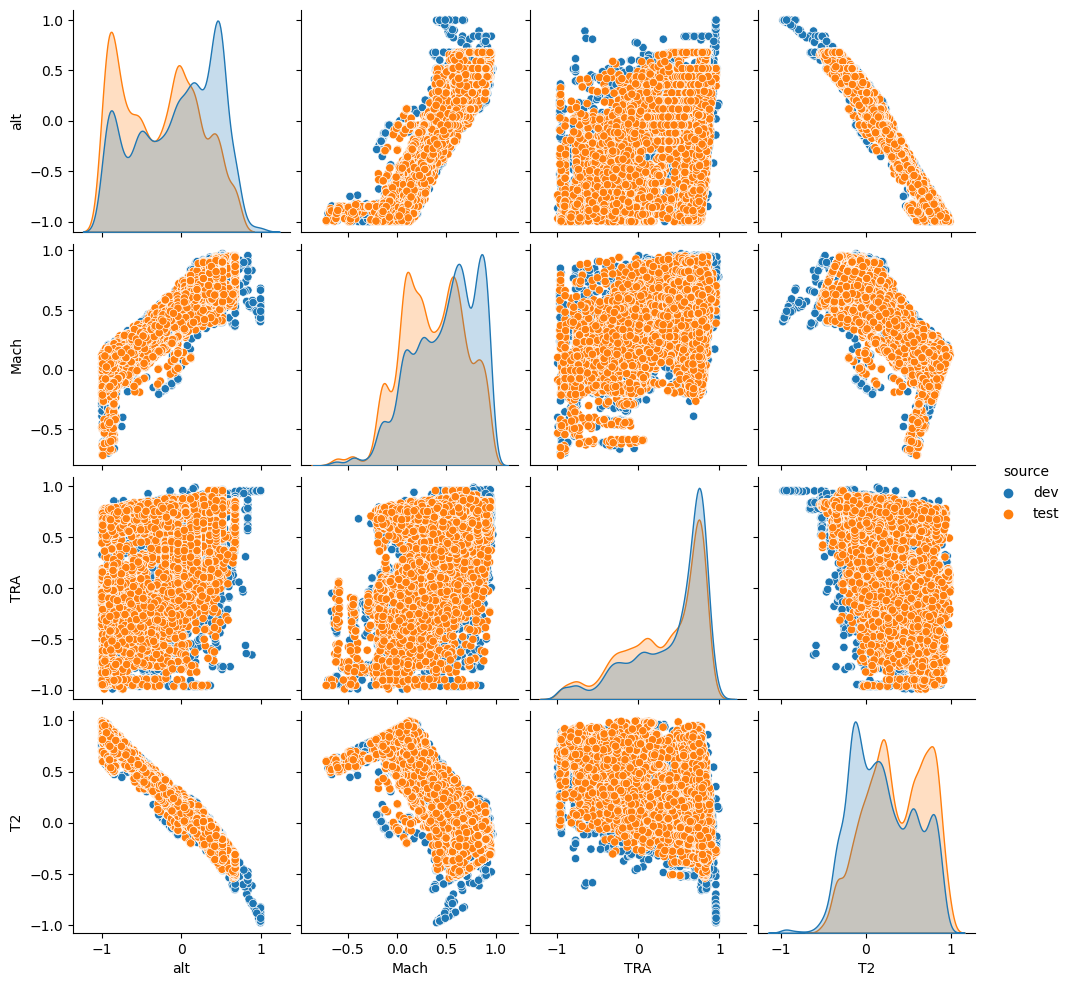

In [11]:
# *** START CODE HERE ***
# Sub set of data
dim, size = W_dev.shape[0], 10000
mask_dev = np.random.choice(dim, size, replace=False)

df_W_dev = pd.DataFrame(W_dev[mask_dev], columns=W_var)
df_W_dev['source']='dev'

dim, size = W_test.shape[0], 10000
mask_test = np.random.choice(dim, size, replace=False)

df_W_test = pd.DataFrame(W_test[mask_test], columns=W_var)
df_W_test['source']='test'

df_W = pd.concat([df_W_dev, df_W_test], ignore_index=True)
sns.pairplot(df_W, hue='source')
### END CODE HERE ###

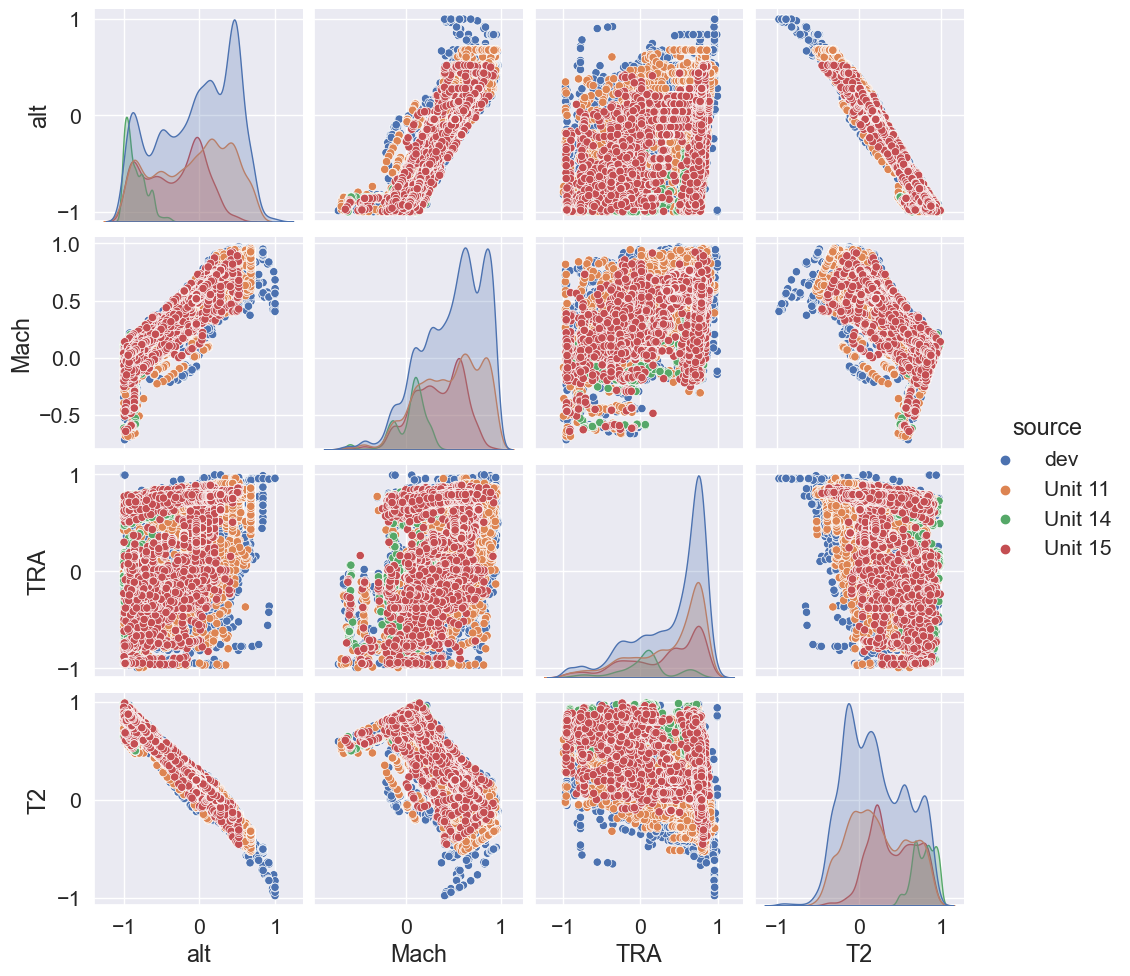

In [12]:
# Sub set of data
dim, size = W_dev.shape[0], 10000
mask_dev = np.sort(np.random.choice(dim, size, replace=False))

df_W_dev = pd.DataFrame(W_dev[mask_dev], columns=W_var)
df_W_dev['source']='dev'

dim, size = W_test.shape[0], 10000
mask_test = np.sort(np.random.choice(dim, size, replace=False))

df_W_test = pd.DataFrame(W_test[mask_test], columns=W_var)
df_W_test['source']= U_test[mask_test]
for unit in np.unique(U_test[mask_test]):
    mask_u = np.ravel(U_test[mask_test] == unit)
    df_W_test.loc[mask_u, 'source'] = 'Unit ' + str(unit)

df_W = pd.concat([df_W_dev, df_W_test], ignore_index=True)

# Plot
sns.set(font_scale=1.4)
sns.pairplot(df_W, hue='source')

**Solution**: It is worth noting that test units 14 and 15 have an operation distribution significantly different from those of the development units. Concretely, test units 14 and 15 operate shorter and lower altitude flights compared to other units. The development dataset contains, therefore, flight profiles that are not fully representative of the test conditions of these two units. 

## Sensor readings $x_s$

**Exercise 0.4 [2 pts]:** Create a visualization of the sensor reading profile during one single flight

**Hint.** Make use of the `plot_variables_iso()` auxiliary function. To subset the data array you can use a `mask` with the criteria

e.g., `mask = np.ravel((U_dev==2) & (C_dev==1))`. --> `Xs_dev[mask,:]`


['T24', 'T30', 'T40', 'T48', 'T50', 'P15', 'P2', 'P21', 'P24', 'Ps30', 'P30', 'P40', 'P50', 'Nf', 'Nc', 'Wf']


<Figure size 640x480 with 0 Axes>

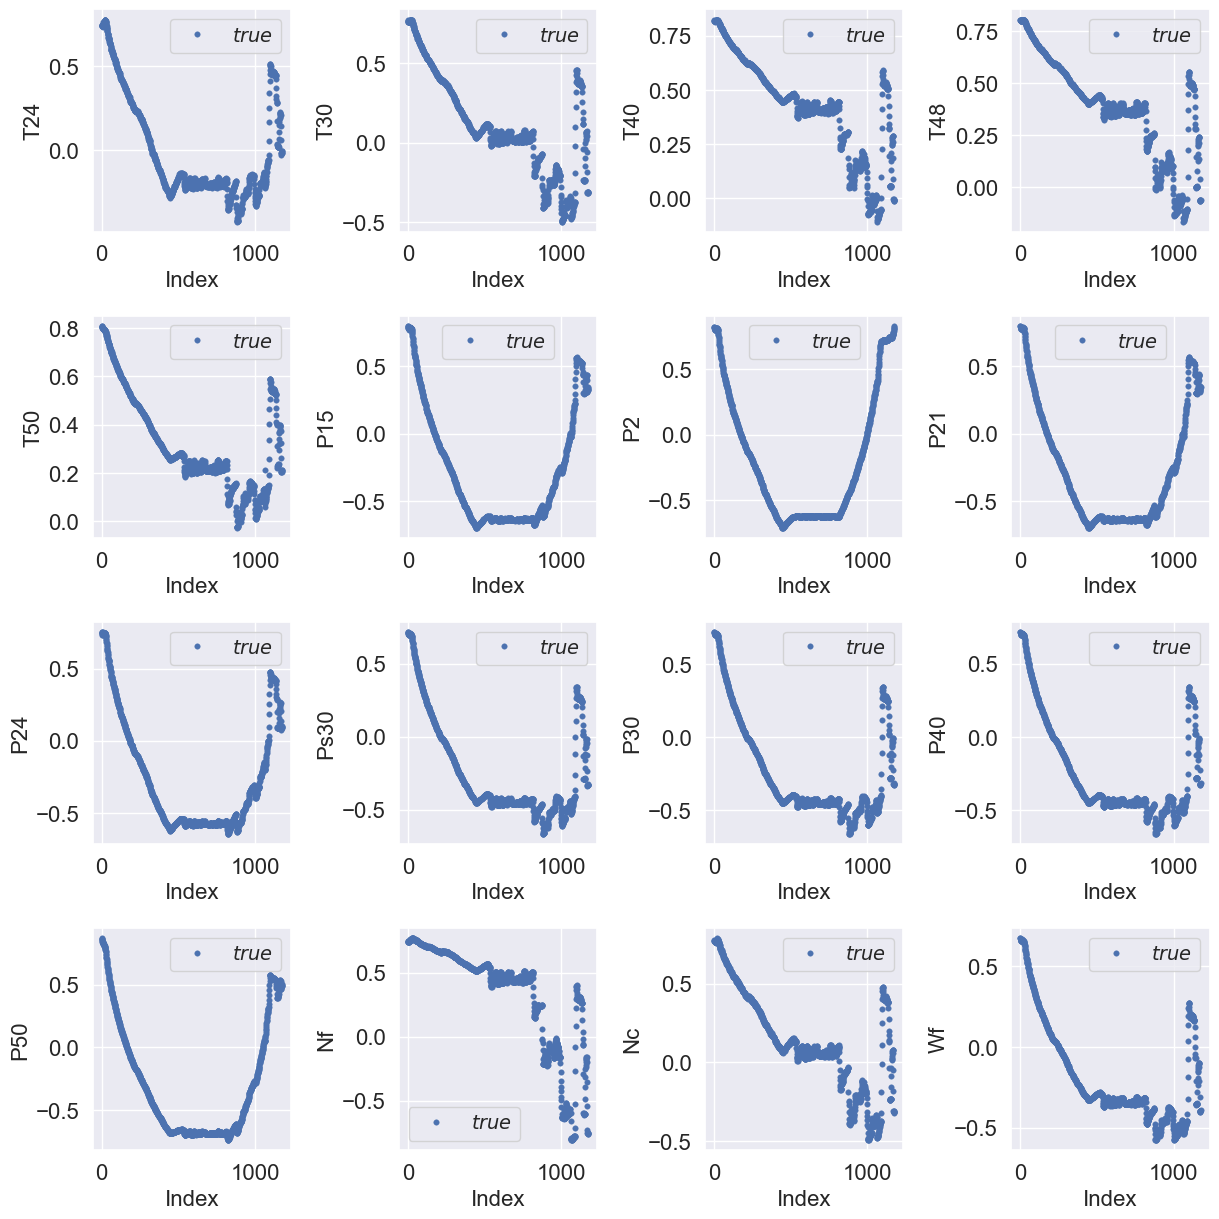

In [13]:
# *** START CODE HERE ***
# Set-up
data, data[0] = {}, {}
data[0]['variables'] = Xs_var       # Variables names
print('')
print(data[0]['variables'])

data[0]['label'] = data[0]['variables']
data[0]['legend'] = ['$true$']
data[0]['ds_name'] = ['true']

# Data to plot
mask = np.ravel((U_dev==2) & (C_dev==1))
data[0]['true'], data[0]['pred'] = {}, {}
data[0]['true']['y'] = Xs_dev[mask,:]
data[0]['true']['x'] = np.arange(data[0]['true']['y'].shape[0])

# Plot
plot_variables_iso(data, figsize=12.5)
### END CODE HERE ###

## Performance Gap Indicators $\theta$

**Exercise 0.4 [2pts]:** Create a visualization of the degradation trajectories provided for development (i.e., N=6 engines) by plotting the traces of the model parameters $\theta$ vs. the time (e.g., variable value Vs. Cycle).


['HPT_eff_mod', 'LPT_eff_mod', 'LPT_flow_mod']


<Figure size 640x480 with 0 Axes>

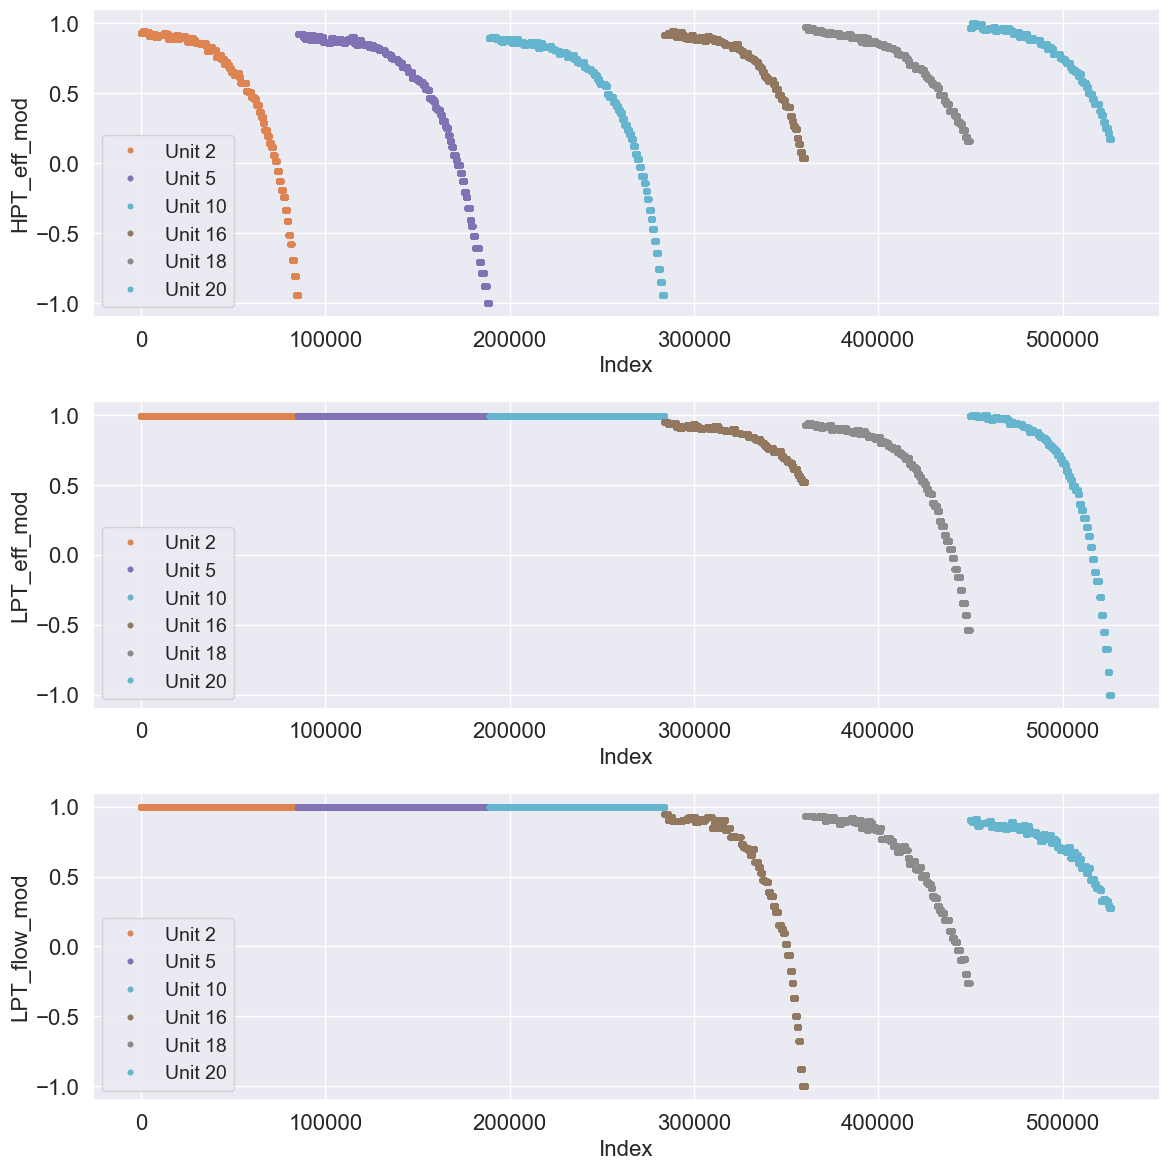

In [14]:
# *** START CODE HERE ***
# Set-up
data, data[0] = {}, {}
data[0]['variables'] = T_var       # Variables names
print('')
print(data[0]['variables'])

data[0]['legend'] = ['$true$']
data[0]['ds_name'] = ['true']
data[0]['option'] = 'unit'
#data[0]['xlabel'] = 'Time [cycles]'

# Data to plot
data[0]['true'], data[0]['pred'] = {}, {}
data[0]['true']['y'] = T_dev
data[0]['true']['x'] = np.arange(data[0]['true']['y'].shape[0])
data[0]['true']['units'] = U_dev, 

# Plot
plot_variables_iso(data, figsize=12)
### END CODE HERE ###

**Solution:** Two distinctive failure modes are present in the available dataset ($\mathcal{D}$). Units 2, 5, and 10 have failure modes of an $\textit{abnormal}$ high-pressure turbine (HPT) efficiency degradation. Units 16, 18, and 20 are subject to a more complex failure mode that affects the low-pressure turbine (LPT) efficiency and flow in combination with the high-pressure turbine (HPT) efficiency degradation. Test units are subjected to the same complex failure mode. The transition time ($t_{s}$) is dependent on the operating conditions, i.e., flight and degradation profile. It should be noted that although the degradation profiles of individual components show nearly overlapping trajectories, the combined profile (i.e., the profile in three dimensions) is clearly different.

#  Part 1 [10 pts]: Data Pre-processing

In this part, we will carry out the pre-processing steps required for the generation of detection, diagnostics, and prognostics models  and provide the following:

**Exercise (2 or 3 pts each)**

1. Create a subset of the available dataset containing only Units 16, 18, and 20
2. Normalize the development and test datasets between 0 and 1.
3. Generation of labeled $D_{L}$ and unlabeled dataset $D_{U}$ by subsetting the available dataset
4. Definition of a target variable 𝑇 for fault detection.

Please notice that the requested pre-processing **is closely related to the ones covered in the practical session in WK11 to 12** and involves the following steps:

Implementing this solution strategy requires the following steps:
* **Step 1.1:** Subsetting development data
* **Step 1.2:** Nomalize dataset
* **Step 1.3:** Generation of labeled $D_{L}$ and unlabeled dataset $D_{U}$ by subsetting the available dataset
* **Step 1.4:** Definition of a target variable $T$

## Step 1.1: Subset development data

As discussed in Part 0, there are two failure modes present in the available dataset ($\mathcal{D}$). Units 2, 5, and 10 have failure modes of an $\textit{abnormal}$ high-pressure turbine (HPT) efficiency degradation. Units 16, 18, and 20 are subject to a more complex failure mode that affects the low-pressure turbine (LPT) efficiency and flows in combination with the high-pressure turbine (HPT) efficiency degradation. Test units are subjected to the same complex failure mode. Therefore, we remove Units 2, 5, and 10 from the available dataset.

**Exercise 1.1 [2 pts]**: Make use of the auxiliary function `extract_units_ds()` to subset the available dataset and create a development dataset with unit 16, 18, and 20 data. Report the shapes of the resulting `np.array()` for all the variables: operative condition `W`, sensor readings `Xs`, performance gap indicators `T`, RUL label `R`, unit number label, `U` and flight cycle number `C`. Denote the resulting variables `{Xs_, T_, W_, C_, U_}_dev`.

In [15]:
# *** START CODE HERE ***

# Create development subset and test datasets
id_en_dev = [16, 18, 20]
W_dev = extract_units_ds(id_en_dev, W_dev, U_dev)
Xs_dev = extract_units_ds(id_en_dev, Xs_dev, U_dev)
T_dev = extract_units_ds(id_en_dev, T_dev, U_dev)
R_dev = extract_units_ds(id_en_dev, R_dev, U_dev)
C_dev = extract_units_ds(id_en_dev, C_dev, U_dev)
U_dev = extract_units_ds(id_en_dev, U_dev, U_dev)

### END CODE HERE ###

print('')
print ("number of examples in the development subset = " + str(Xs_dev.shape[0]))
print ("Xs_dev shape: " + str(Xs_dev.shape))
print ("T_dev shape: " + str(T_dev.shape))
print ("W_dev shape: " + str(W_dev.shape))
print ("U_dev shape: " + str(U_dev.shape))
print ("C_dev shape: " + str(C_dev.shape))

print('')
print ("number of examples in the test subset = " + str(Xs_test.shape[0]))
print ("Xs_test shape: " + str(Xs_test.shape))
print ("T_test shape: " + str(T_test.shape))
print ("W_test shape: " + str(W_test.shape))
print ("U_test shape: " + str(U_test.shape))
print ("C_test shape: " + str(C_test.shape))


number of examples in the development subset = 242418
Xs_dev shape: (242418, 16)
T_dev shape: (242418, 3)
W_dev shape: (242418, 4)
U_dev shape: (242418, 1)
C_dev shape: (242418, 1)

number of examples in the test subset = 125375
Xs_test shape: (125375, 16)
T_test shape: (125375, 3)
W_test shape: (125375, 4)
U_test shape: (125375, 1)
C_test shape: (125375, 1)


## Step 1.2: Normalizing data

As discussed in the practical session, a common technique we use in Machine Learning is to normalize our data. It often leads to a better performance because gradient descent converges faster after normalization.

The provided dataset is normalized with a 'max-min' approach to values -1 to 1. While this is common in  Machine Learning pipelines, we will renormalize to only positive values, i.e., 0 to 1.

**Exercise 1.2 [3 pts]:** Use the provided auxiliary function `normalize_data()` to renormalize the development and test datasets to only positive values, i.e., 0 to 1. Provide the resulting `np.array()` for all the variables: operative condition `W`, sensor readings `Xs`, and performance gap indicators `T`. Create a plot to show that, indeed, the variables have been correctly normalized.

In [16]:
# *** START CODE HERE ***
# Sensor readings
Xs_dev, lb, ub = normalize_data(Xs_dev, [], [], max_v=1.0, min_v=0.0)
Xs_test, _, _ = normalize_data(Xs_test, lb, ub, max_v=1.0, min_v=0.0)

# Operative conditions
W_dev, lb, ub = normalize_data(W_dev, [], [], max_v=1.0, min_v=0.0)
W_test, _, _ = normalize_data(W_test, lb, ub, max_v=1.0, min_v=0.0)

# T conditions
T_dev, lb, ub = normalize_data(T_dev, [], [], max_v=1.0, min_v=0.0)
T_test, _, _ = normalize_data(T_test, lb, ub, max_v=1.0, min_v=0.0)

### END CODE HERE ###

print('')
print ("number of examples in the development subset = " + str(Xs_dev.shape[0]))
print ("Xs_dev shape: " + str(Xs_dev.shape))
print ("W_dev shape: " + str(W_dev.shape))
print ("T_dev shape: " + str(T_dev.shape))

print('')
print ("number of data examples = " + str(Xs_test.shape[0]))
print ("Xs_test shape: " + str(Xs_test.shape))
print ("W_test shape: " + str(W_test.shape))
print ("T_test shape: " + str(T_test.shape))


number of examples in the development subset = 242418
Xs_dev shape: (242418, 16)
W_dev shape: (242418, 4)
T_dev shape: (242418, 3)

number of data examples = 125375
Xs_test shape: (125375, 16)
W_test shape: (125375, 4)
T_test shape: (125375, 3)


C:\Users\aria\AppData\Local\Temp\ipykernel_16772\2900215502.py:17: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if (lb == []) & (ub == []):


## Step 1.3: Generation of labeled $\mathcal{D}_{L}$ and unlabeled dataset $\mathcal{D}_{U}$ by subsetting the available dataset

As discussed in the anomaly detection covered in the practical session of WK 11 and introduced in Part 3, we need to model the healthy system state. Therefore, in this notebook, we will create a fully labeled dataset ($\mathcal{D}_{L}$) of healthy system conditions (i.e., $h_s^{(i)}=1$) and an unlabeled dataset with unknown health conditions (i.e., $h_s^{(i)}=?$) using the development data. 

Since the information about health state is not provided in the dataset, we will use a very simple approach to come up with these two sets of data. We assume cycles below or equal to `split_cycle=20` are labeled healthy i.e., $h_s^{(i)}=1$ and the remaining are unlabeled.

**Exercise 1.3 [3 pts]:** Use the provided auxiliary function `data_subset()` to obtain the labeled $\mathcal{D}_{L}$ and unlabeled dataset $\mathcal{D}_{U}$.  Report the resulting `np.array()` shapes for all the variables: operative condition `W`, sensor readings `Xs`,  unit number `U`,  cycle number `C`, and lagged sensor readings `_Xs`.

In [17]:
# *** START CODE HERE ***
U_sel = np.unique(U_dev)
W_lab, W_unl = data_subset(W_dev, U_dev, C_dev, U_sel, split_cycle=20)
Xs_lab, Xs_unl = data_subset(Xs_dev, U_dev, C_dev, U_sel, split_cycle=20)
U_lab, U_unl = data_subset(U_dev, U_dev, C_dev, U_sel, split_cycle=20)
C_lab, C_unl = data_subset(C_dev, U_dev, C_dev, U_sel, split_cycle=20)
### END CODE HERE ###

print("")
print ("number of labeled examples = " + str(Xs_lab.shape[0]))
print ("W_lab shape: " + str(W_lab.shape))
print ("Xs_lab shape: " + str(Xs_lab.shape))
print ("U_lab shape: " + str(U_lab.shape))
print ("C_lab shape: " + str(C_lab.shape))
print("")
print ("number of unlabeled examples = " + str(Xs_unl.shape[0]))
print ("W_unl shape: " + str(W_unl.shape))
print ("Xs_unl shape: " + str(Xs_unl.shape))
print ("U_unl shape: " + str(U_unl.shape))
print ("C_unl shape: " + str(C_unl.shape))


number of labeled examples = 73824
W_lab shape: (73824, 4)
Xs_lab shape: (73824, 16)
U_lab shape: (73824, 1)
C_lab shape: (73824, 1)

number of unlabeled examples = 168594
W_unl shape: (168594, 4)
Xs_unl shape: (168594, 16)
U_unl shape: (168594, 1)
C_unl shape: (168594, 1)


## Step 1.4: Generating training $\mathcal{S}_{T}$ and validation datasets $\mathcal{S}_{V}$

**Exercise 1.4 [2 pts]:** Create the training and validation dataset for the labeled, and development datasets. Report the resulting  shapes.

In [18]:
# *** START CODE HERE ***
# Validation as subset of development data
indices = np.arange(Xs_dev.shape[0])
idx_train, idx_val = train_test_split(indices, test_size=0.10, random_state=42, shuffle=True)

W_val = W_dev[np.sort(idx_val)]
Xs_val = Xs_dev[np.sort(idx_val)]         
U_val = U_dev[np.sort(idx_val)]
C_val = C_dev[np.sort(idx_val)]
R_val = R_dev[np.sort(idx_val)]

W_train = W_dev[np.sort(idx_train)]
Xs_train = Xs_dev[np.sort(idx_train)]
U_train = U_dev[np.sort(idx_train)]
C_train = C_dev[np.sort(idx_train)]
R_train = R_dev[np.sort(idx_train)]
### END CODE HERE ###

# Validation as subset of labeled data
indices = np.arange(Xs_lab.shape[0])
idx_lab, idx_labval = train_test_split(indices, test_size=0.10, random_state=42, shuffle=True)

W_lab_val = W_lab[np.sort(idx_labval)]
Xs_lab_val = Xs_lab[np.sort(idx_labval)]
U_lab_val = U_lab[np.sort(idx_labval)]
C_lab_val = C_lab[np.sort(idx_labval)]

W_lab_train = W_lab[np.sort(idx_lab)]
Xs_lab_train = Xs_lab[np.sort(idx_lab)]
U_lab_train = U_lab[np.sort(idx_lab)]
C_lab_train = C_lab[np.sort(idx_lab)]

# Part 2: Create baseline model with MLP $[w, x_s] \rightarrow R$

As mentioned in the introduciton, since we have a dataset of input and output variables i.e., $\mathcal{D} =\{x_i, y_i\}_{i=1}^{N}$ with $x_i= [w_i, x_{s_i}] \in R^n$, we will follow a standard supervised learning approach aiming to learn a mapping function from the CM signals to the RUL target $\mathbf{y}$ (i.e., $\mathcal{G}: \mathbf{x} \longmapsto \mathbf{y}$). Once we discover an optimal mapping $\mathcal{G}$ we can used it to predict RUL on the test dataset $\mathcal{D}_{T*}$.


**Mathematically**:
\begin{align} \label{eq:prognostic}
\hat{y}^{(j)} \sim \mathbf{\mathcal{G}}(w^{(t)}_*, x^{(j)}_{s*}; \mathcal{H})
\end{align}

In particular, the chosen method used a multilayer perceptron (MLP) i.e., a fully connected feedforward neural network. This will be introduced in WK13. For now, just take it as given and try to familiarize yourself with the provided code.

The provided code contains four functions:
1. `create_supervised_X(X, output_shape, config)`
2. `create_supervised(input_shape, output_shape, config)`
4. `fit_model(MODEL_PATH, X_{train, val, test}, Y_{train, val, test}, config)`
5. `grid_search(MODEL_PATH, X_{train, val, test}, Y_{train, val, test}, config, n_runs)`

In [19]:
def create_supervised_X(X, output_shape, config):
    """
    inputs:
        input_shape: tuple with input shape
        output_shape: integer with output shape
        config: dictionary with NN configuration i.e. hyperparameters) but ...
    outputs:
        X: output layer        
    """
    
    # Set-up
    n_dense = config['n_hl']-1  # The number of hidden of layers minus the output layer
    cells = [config['n_cl'] for i in range(n_dense)]
       
    # Hidden layers
    for i in range(n_dense):
        X = tf.keras.layers.Dense(cells[i], 
                                  activation=config['activ'],
                                  kernel_initializer=tf.keras.initializers.glorot_uniform(seed=config['seed']))(X) 
    
    # Dropout layer 
    if config['dropout'] != 0.0:
        X = tf.keras.layers.Dropout(config['dropout'])(X)
    
    # Hidden fully connected linear layer (no activation)
    X = tf.keras.layers.Dense(config['n_fc'],
                              kernel_initializer=tf.keras.initializers.glorot_uniform(seed=config['seed']))(X)
    
    # Output layer
    X = tf.keras.layers.Dense(output_shape)(X)

    return X

def create_supervised(input_shape, output_shape, config):
    """
    inputs:
        input_shape: tuple with input shape
        output_shape: integer with output shape
        config: dictionary with NN configuration i.e. hyperparameters) but ...
    outputs:
        supervised: tf model        
    """
      
    # Define the input placeholder as a tensor with shape input_shape    
    X_input = tf.keras.Input(shape=input_shape)

    # Create model
    X = create_supervised_X(X_input, output_shape, config)
    supervised = tf.keras.Model(inputs=X_input, outputs=X, name='supervised')
       
    # Optimisation 
    opt = tf.keras.optimizers.legacy.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=True)

    # Compilation
    supervised.compile(loss=tf.losses.MeanSquaredError(), optimizer=opt)
    
    return supervised

def train_model(OUTFOLDER, 
                X_train, Y_train, 
                X_val, Y_val,
                X_test, Y_test, 
                config, label, generate):
    """
    Creates and trains a NN with supervised learning strategy: 
    define model shapes, create model, fit model, plot training loss and save model
    inputs:
        OUTFOLDER: path to storage or model folder
        X_{train, val, test}: np.array with train and test input features.
        Y_{train, val, test}: np.array with train and test target features.
        config: dictionary with NN configuration (i.e. hyperparameters) but ...
        label: str with model name for storage or loading
        generate_s: boolean with load or run.
    outputs:
        loss_{Tr, Va, Ts}: np.array with loss in train, val and test datasets
        y_hat_{train, test}: np.array with train, val and test input predictions.        
    """       
    
    if generate:

        # Set-up
        seed = 229
        os.environ['PYTHONHASHSEED'] = '0'
        np.random.seed(seed)
        tf.keras.backend.clear_session()
                        
        # Define model shapes
        input_shape = X_train.shape[1:]
        output_shape = Y_train.shape[-1]
        
        # Create supervised model
        supervised = create_supervised(input_shape, output_shape, config)

        # Report model summary
        supervised.summary()
        
        # Callbacks
        early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=config['patience'], 
                                                      restore_best_weights = True)

        # Fit model
        history = supervised.fit(X_train, Y_train, 
                                 epochs=config['epochs'],
                                 batch_size=config['batch_size'],
                                 callbacks=[early_stop],
                                 validation_data = (X_val, Y_val),
                                 verbose=1)

        # Evaluate model loss i.e. MSE
        loss_train = supervised.evaluate(x=X_train, y=Y_train)
        loss_val = supervised.evaluate(x=X_val, y=Y_val)
        loss_test = supervised.evaluate(x=X_test, y=Y_test)

        # Plot history loss
        plt.plot(np.sqrt(history.history['loss']))
        plt.plot(np.sqrt(history.history['val_loss']))
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'val'], loc='upper left')
        plt.show()

        # Save supervised model
        supervised.save(OUTFOLDER + 'model_' + str(label) + '.h5')
        print("Saved supervised model to disk")
        
    else:
        # Supervised
        supervised = tf.keras.models.load_model(OUTFOLDER + 'model_' + str(label) + '.h5')
        print("Loaded supervised model from disk")

        # Report model summary
        supervised.summary()

        # Compilation
        supervised.compile(optimizer='Adam', loss="mean_squared_error") 

        # Evaluate model i.e. RMS       
        loss_train = supervised.evaluate(x=X_train, y=Y_train)
        loss_val = supervised.evaluate(x=X_test, y=Y_test)
        loss_test = supervised.evaluate(x=X_test, y=Y_test)
    
    # Target predictions
    y_hat_train = supervised.predict(x=X_train)
    y_hat_test = supervised.predict(x=X_test)
    
    return loss_train, loss_val, loss_test, y_hat_train, y_hat_test

def grid_search(MODEL_PATH,
                X_train, Y_train, 
                X_val, Y_val,
                X_test, Y_test, 
                params, n_runs, varInput, generate=True):
    """
    Performs a grid search in a NN with supervised learning strategy: 
    define model shapes, create models, fit models, plot training loss and save models
    inputs:
        MODEL_PATH: path to storage or model folder.
        X_{train, val, test}: np.array with train, val and test input features.
        Y_{train, val, test}: np.array with train, val and test target features.
        params: dictionary, NN possible configurations.
        n_runs: int, each configuration is performed n_runs times.
        varInput: str with mapping label.
        generate: boolean with load or run.
    outputs:
        df: storage dataframe.
        label_best: label of best model.
        ...
        ...
        
    """
    # Set-up
    log_Y_hat_train, log_Y_hat_test, log_loss_val, log_label, log_df = [], [], [], [], []
    df = pd.DataFrame()
    log_loss_val, log_label = [], []
    keys, values = zip(*params.items())
    
    for ii, bundle in enumerate(product(*values)):        # Varing architectures        
        config = dict(zip(keys, bundle))                  # Architecture
        
        for jj in range(n_runs):                          # Check reproducibility - n runs            
            df_k = pd.DataFrame(config, index=[0])
            
            # Simulation label
            label =  varInput + '_h_' + str(ii) +  '_run_' + str(jj)
            print('')
            print('Simulation:', label)

            # Train NN model
            time_start = time.time()
            loss_train, loss_val, loss_test, Y_hat_train, Y_hat_test = \
            train_model(MODEL_PATH, 
                        X_train, Y_train,
                        X_val, Y_val,
                        X_test, Y_test, 
                        config, label, generate=generate)

            # Store results
            log_Y_hat_train.append(Y_hat_train)
            log_Y_hat_test.append(Y_hat_test)
            log_loss_val.append(loss_val)
            log_label.append(label)
            
            # Global log of results
            df_k['run']= jj
            df_k['input'] = varInput
            df_k['RMSE-Ts'] = np.round(np.sqrt(np.mean((Y_hat_test - Y_test)**2)), 3)
            df_k['RMSE-Tr'] = np.round(np.sqrt(np.mean((Y_hat_train - Y_train)**2)), 3)
            df_k['Time[min]'] = np.round((time.time()-time_start)/60, 2)            
            log_df.append(df_k)
            df = pd.concat(log_df, ignore_index=True)
            print('')
            print(df.to_string())

            # Write solutions to 
            df.to_csv(MODEL_PATH + 'Training_' +  varInput + '.csv')

    return log_Y_hat_train, log_Y_hat_test, df, log_loss_val, log_label

## Define model architecture 

The code below initializes the necessary parameters for building and training a neural network for supervised learning. It defines possible values for various hyperparameters such as the activation function, number of hidden layers, number of neurons per hidden layer, and batch size, and creates a list of all possible combinations of these hyperparameters.

The `n_runs` variable specifies the number of times each architecture will be trained and evaluated. The `generate_s` flag is set to True by default, which generates new architectures for training. Finally, a Pandas DataFrame is created to store the results of the training, which includes various metrics such as loss, RMSE, and training time.

In [20]:
# Supervised network
params = {"activ": ['relu'],    # Activation - h1 = ['tanh', 'relu']
          "n_hl": [3],          # Number of hidden layers - h2 = [1, 2, 3]
          "n_cl":  [100],       # Number of neurons per hidden layer (the same for all) - h3 = [50, 100, 150]   
          "n_fc": [50],         # Number of neurons in fully connected layer - h4 = [50, 100, 200]
          "dropout": [0.2],     # Dropout - h5 = [0.1, 0.2, 0.5]
          "batch_size": [64],   # Batch size - h6 = [64, 512, 1024]    
          "epochs": [80],       # Epochs - h7 (on demand) 400
          "seed": [229],        # Seed
          "patience": [15]
          }

# Number of runs per NN architecture
n_runs = 1

## Fit model


Simulation: W_Xs-R_h_0_run_0
Model: "supervised"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 20)]              0         
                                                                 
 dense (Dense)               (None, 100)               2100      
                                                                 
 dense_1 (Dense)             (None, 100)               10100     
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_2 (Dense)             (None, 50)                5050      
                                                                 
 dense_3 (Dense)             (None, 1)                 51        
                                                                 
Total params: 17,301
Train

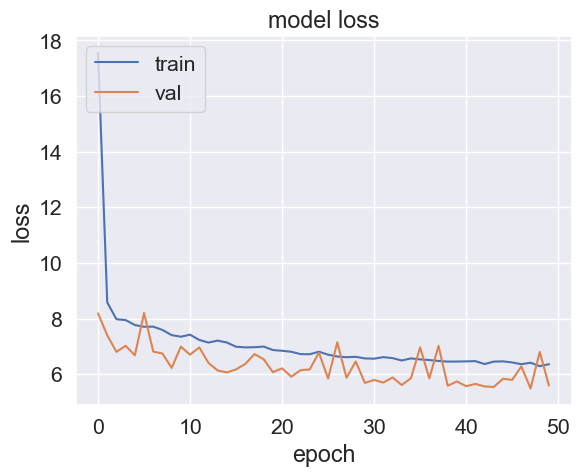

Saved supervised model to disk
3918/3918 [==============================] - 5s 1ms/step

  activ  n_hl  n_cl  n_fc  dropout  batch_size  epochs  seed  patience  run   input  RMSE-Ts  RMSE-Tr  Time[min]
0  relu     3   100    50      0.2          64      50   229        15    0  W_Xs-R    6.253    5.576       6.12


In [21]:
if simSel['Part2']:
    # Set-up
    ROOT_PATH_2 = ROOT_PATH + 'models/00-SL-Part2-MLP'
    MODEL_PATH_2 = ROOT_PATH_2  + '/DS02_' + strftime("%Y-%m-%d", gmtime()) + '/'
    if not os.path.exists(MODEL_PATH_2):
        os.makedirs(MODEL_PATH_2)

    # Inputs
    X_train = np.concatenate((W_train, Xs_train), axis=-1)
    X_val = np.concatenate((W_val, Xs_val), axis=-1)
    X_test = np.concatenate((W_test, Xs_test), axis=-1)    

    # Outputs
    Y_train = R_train
    Y_val = R_val
    Y_test = R_test

    # Model tag 
    input_s = 'W_Xs'      
    target_s = 'R' 
    varInput = input_s + '-' + target_s
    var_names = Xs_var

    # Fit model
    log_Y_hat_train, log_Y_hat_test, df, log_loss_val, log_label_2 = grid_search(MODEL_PATH_2, 
                                                                     X_train, Y_train, 
                                                                     X_val, Y_val,
                                                                     X_test, Y_test,
                                                                     params, n_runs, varInput, generate=True)

## Report model performance and plots

In [22]:
if simSel['Part2']:
    # Evaluate RUL performance
    log_loss_val = np.array(log_loss_val)
    mask = np.ravel(log_loss_val==min(log_loss_val))
    label_2 = list(itertools.compress(log_label_2, mask))[0]
    baseline_model = tf.keras.models.load_model(MODEL_PATH_2 + 'model_' + str(label_2) + '.h5')
    Y_hat_train_2 = baseline_model.predict(x=X_train)
    Y_hat_test_2 = baseline_model.predict(x=X_test)

    print('')
    print('Data-driven: ' + varInput)
    print('RMSE Test:', np.round(np.sqrt(np.mean((Y_hat_test_2 - Y_test)**2)),3))

3918/3918 [==============================] - 5s 1ms/step

Data-driven: W_Xs-R
RMSE Test: 6.253


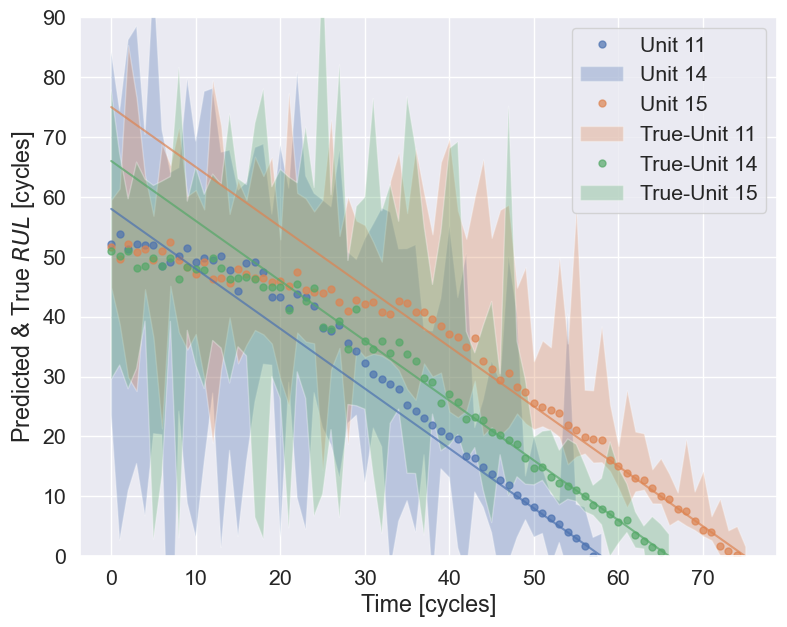

In [23]:
if simSel['Part2']:
    unit_sel = [11, 14, 15]
    plot_predicted_true_rul([Y_hat_test_2], unit_sel, U_test, C_test, Y_test)

# Part 3 [40 pts]: Create a diagnostics model $D$ with MLP

## Solution strategy (as in WK 12)

To simultaneously detect and isolate the faulty conditions, we will resort to a dynamic model that emulates the healthy behavior of the system. Once the model is available will compute the residual approach explained in the lectures. The residuals (i.e., the delta between sensor readings and model predictions) allow isolating which sensors are most affected by a fault.

Implementing this solution strategy requires the following steps:

* **Step 3.1:** Create a model $D$ of the healthy system response i.e. sensor readings $x_s^{(t)} \in \mathcal{D}_{L}$ of the system.
* **Step 3.2:** Compute the expected i.e., model predictions response of the system $\hat{x}_s^{(t)}$
* **Step 3.3:** Compute residuals between sensor readings $x_s^{(t)}$ and model predictions $\hat{x}_s^{(t)}$.
* **Step 3.4:** Identify residual with larger deviations. Hopefully, they indicate the location of the fault. 

**Step 3.1:** Model (learn) the healthy response of the system i.e. sensor readings $x_s^{(t)} \in \mathcal{D}_{L}$
In particular we will consider the following dynamical system $D$ that approximates the expected system response given the  control variables $w^{(t)}$, resulting in:

\begin{equation}
  {x_s}^{(t)} = D(w^{(t)})
\end{equation}

We will model $D$ with an MLP.

**Step 3.2:** Compute the expected, i.e., model predictions $\hat{x}_s^{(t)}$ in the $\{\mathcal{D}_{U}, \mathcal{D}_{T_*}\}$. 
Once $D$ is learned with $[w^{(t)}] \in \mathcal{D}_{L}$ then it can be used to compute predictions i.e., sensor readings ($x_{s*}^{(t)}$) given new operative conditions i.e.,  $[w_*^{(t)}] \in \{\mathcal{D}_{U}, \mathcal{D}_{T_*}\}$. 

\begin{equation}
  {\hat{x}_s}^{(t)} = D(w^{(t)})
\end{equation}

**Step 3.3:** Compute residuals between sensor readings $x_s^{(t)}$ and model predictions $\hat{x}_s^{(t)}$.

\begin{equation} \label{eq:model}
  r^{(t)}= {x_s}^{(t)} - {\hat{x}_s}^{(t)} 
\end{equation}

**Step 3.4:** Identify residuals with larger deviations. 
We will follow a similar approach as in the fault detection notebook. In particular, we will apply the same method to each output signal.

The dynamical system $D$ allows to compute the expected signal values under the training distribution (i.e. $\mathcal{D}_{L}$). The output of the $D$ i.e., $\hat{x}_s^{(t)}$ will deviate from the input value $x_s$ when the inner relationship of a new data point $x^{(j)} \in \{\mathcal{D}_{U},\mathcal{D_{T}}\}$ does not correspond to the one observed in the training set $\mathcal{D}_{L}$. Therefore, we compute the absolute deviation that each component of the reconstructed signals has (i.e. $|x_k^{(j)}- D(w^{(j)})_k|$) relative to the error observed in the labeled dataset $\mathcal{D}_{L}$ (i.e. healthy operation conditions).

\begin{equation} \label{eq:isolation}
  d_I(x_k^{(j)};\nu_k) =  \frac{|x_k^{(j)}- D(w^{(j)})_k|}{\nu_k}
\end{equation}

where $\nu$ corresponds to a normalizing threshold given by the 99.9\% percentile of the absolute error of the prediction of $D$ in the labeled dataset $\mathcal{D}_{L}$


\begin{equation}
  \nu_k = P_{99.9}\big(\{|x_k^{(j)} - D(w^{(j)})_k| \; \forall \; x_k^{(i)}\in \mathcal{D}_{L}\}\big) % \; \forall
\end{equation}

$d_I(x_k^{(j)};\nu)$ is an unbounded measure of similarity between the signal value predicted by the system dynamic model and the expected or actual measurement. 

## Step 3.1: Create a dynamic model $\mathbf{\mathcal{D}}$ with a MLP.


**Exercise 3.1 [3 pts]:** Define the input and output variables for this model for training, validation and test datasets i.e., `X_{train, val, test}` and `Y_{train, val, test}`.

In [24]:
# Supervised network
params = {"activ": ['relu'],    # Activation - h1 = ['tanh', 'relu']
          "n_hl": [4],          # Number of hidden layers - h2 = [1, 2, 3]
          "n_cl":  [100],       # Number of neurons per hidden layer (the same for all) - h3 = [50, 100, 150]   
          "n_fc": [50],         # Number of neurons in fully connected layer - h4 = [50, 100, 200]
          "dropout": [0.0],     # Dropout - h5 = [0.1, 0.2, 0.5]
          "batch_size": [64],   # Batch size - h6 = [64, 512, 1024]    
          "epochs": [50],       # Epochs - h7 (on demand) 400
          "seed": [229],        # Seed
          "patience": [15]
          }

# Number of runs per NN architecture
n_runs = 1


Simulation: W_Xs-Xs_h_0_run_0
Model: "supervised"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 4)]               0         
                                                                 
 dense (Dense)               (None, 100)               500       
                                                                 
 dense_1 (Dense)             (None, 100)               10100     
                                                                 
 dense_2 (Dense)             (None, 100)               10100     
                                                                 
 dense_3 (Dense)             (None, 50)                5050      
                                                                 
 dense_4 (Dense)             (None, 16)                816       
                                                                 
Total params: 26,566
Trai

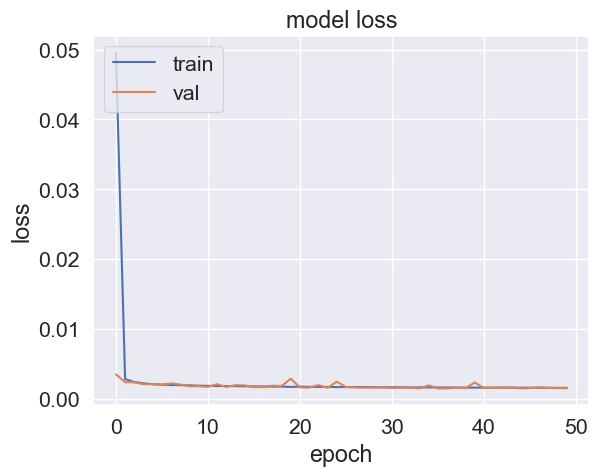

Saved supervised model to disk
3918/3918 [==============================] - 4s 1ms/step

  activ  n_hl  n_cl  n_fc  dropout  batch_size  epochs  seed  patience  run    input  RMSE-Ts  RMSE-Tr  Time[min]
0  relu     4   100    50      0.0          64      50   229        15    0  W_Xs-Xs    0.006    0.002       2.28


In [25]:
if simSel['Part3']:
    # Set-up
    ROOT_PATH_3 = ROOT_PATH + 'models/00-SL-Part3-MLP'
    MODEL_PATH_3 = ROOT_PATH_3  + '/DS02_' + strftime("%Y-%m-%d", gmtime()) + '/'
    if not os.path.exists(MODEL_PATH_3):
        os.makedirs(MODEL_PATH_3)

    # Inputs
    X_train = W_lab_train
    X_val = W_lab_val
    X_test = W_test

    # Targets
    Y_train = Xs_lab_train
    Y_val = Xs_lab_val
    Y_test = Xs_test

    # Model tag 
    input_s = 'W_Xs'      
    target_s = 'Xs' 
    varInput = input_s + '-' + target_s
    var_names = Xs_var

    # Fit model
    log_Y_hat_train, log_Y_hat_test, df, log_loss_val, log_label_3 = grid_search(MODEL_PATH_3, 
                                                                     X_train, Y_train, 
                                                                     X_val, Y_val,
                                                                     X_test, Y_test,
                                                                     params, n_runs, varInput, generate=True)

## Step 3.2: Compute model predictions on labeled ($\mathcal{D}_{L}$), training, and test $\mathcal{D}_{T_*}$ datasets

**Exercise 3.2 [5 pts]:** Compute predictions of the detection model on labeled, training and test datasets i.e., `Xs_hat_lab`, `Xs_hat_train` and `Xs_hat_test`. Plot the true and predicted values for subset of the test dataset (for instance the last 1000 samples) Explain the results.and predicted values for subset of the test dataset (for instance the last 1000 samples) Explain the results.

**Hint:** You can load the detection model fitted in Step 3.1 as follows:
`dynamical_model = tf.keras.models.load_model(MODEL_PATH_3 + 'model_' + str(label_3) + '.h5')`

In [26]:
# Select model with best loss on validation set!!
log_loss_val = np.array(log_loss_val)
mask = np.ravel(log_loss_val==min(log_loss_val))
label_3 = list(itertools.compress(log_label_3, mask))[0]

# *** START CODE HERE ***
dynamical_model = tf.keras.models.load_model(MODEL_PATH_3 + 'model_' + str(label_3) + '.h5')
Xs_hat_lab = dynamical_model.predict(x=W_lab)
Xs_hat_train = dynamical_model.predict(x=W_train)
Xs_hat_val = dynamical_model.predict(x=W_val)
Xs_hat_test = dynamical_model.predict(x=W_test)
### END CODE HERE ###

3918/3918 [==============================] - 4s 1ms/step



['T24', 'T30', 'T40', 'T48', 'T50', 'P15', 'P2', 'P21', 'P24', 'Ps30', 'P30', 'P40', 'P50', 'Nf', 'Nc', 'Wf']


<Figure size 640x480 with 0 Axes>

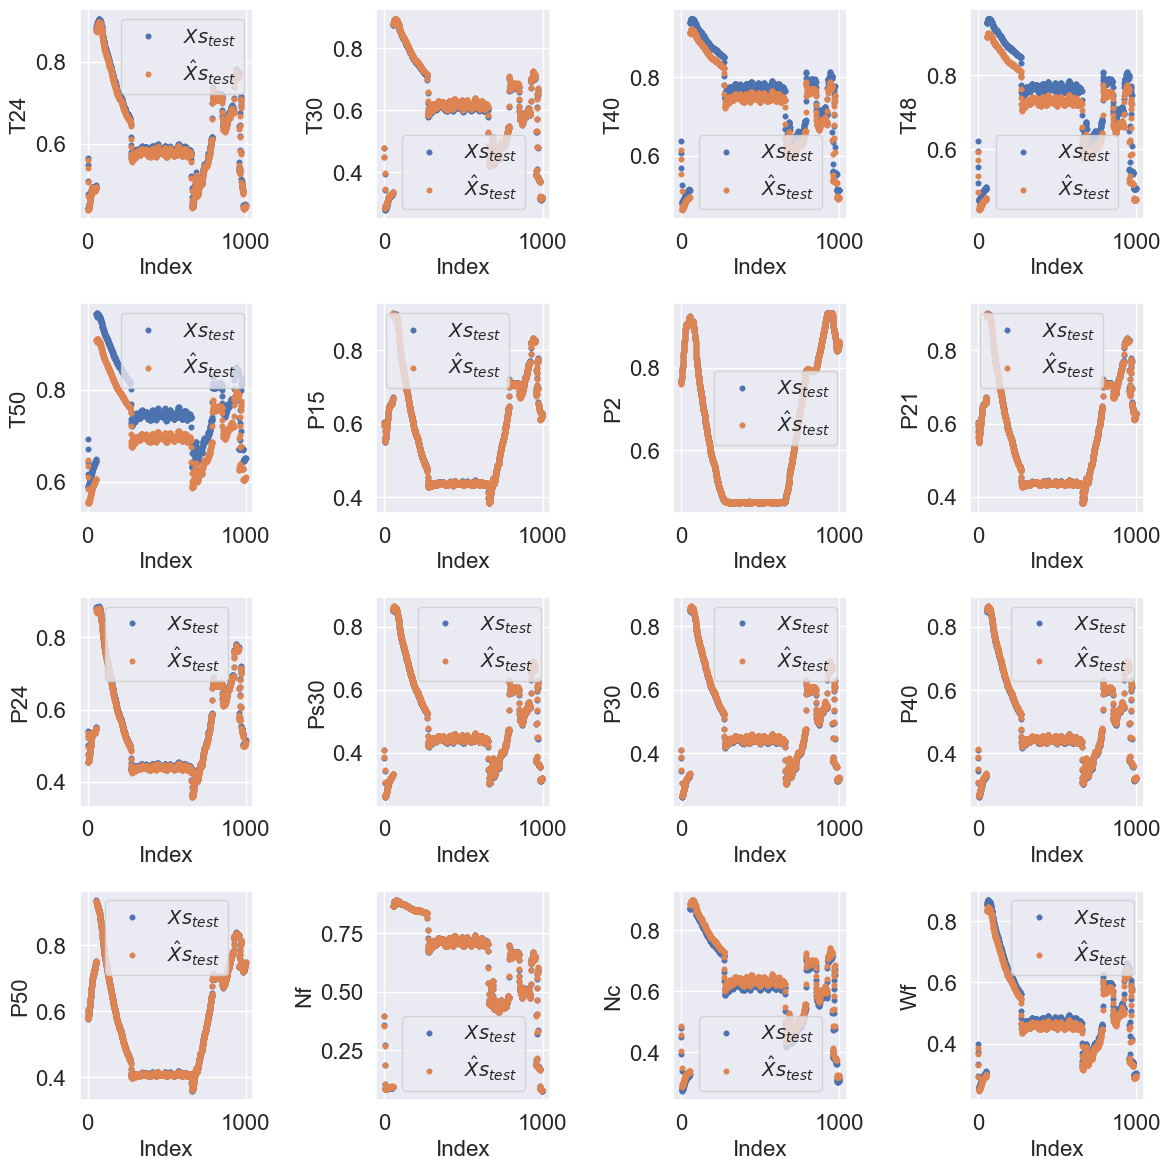

In [27]:
data, data[0] = {}, {}
data[0]['variables'] = Xs_var
print('')
print(data[0]['variables'])

data[0]['label'] = data[0]['variables']
data[0]['legend'] = ['$Xs_{test}$', '$\hat{X}s_{test}$']
data[0]['ds_name'] = ['true', 'pred']
data[0]['color'] = ['C0', 'C1']

# Data to plot
data[0]['true'] = {}
data[0]['true']['y'] = Xs_test[-1000:,:]
data[0]['true']['x'] = np.arange(data[0]['true']['y'].shape[0])

data[0]['pred'] = {}
data[0]['pred']['y'] = Xs_hat_test[-1000:,:]
data[0]['pred']['x'] = np.arange(data[0]['pred']['y'].shape[0])

# Plot limits
x_max = None              # Max x
y_min = None              # Min y
y_max = None              # Max y

# Plot
plot_variables_iso(data, figsize=12)

## Step 3.3: Compute residuals between sensor readings $x_s^{(t)}$ and model predictions $\hat{x}_s^{(t)}$ on labeled ($\mathcal{D}_{L}$), training,  and test $\mathcal{D}_{T_*}$ datasets

\begin{equation} 
  r^{(t)}= {x_s}^{(t)} - {\hat{x}_s}^{(t)} 
\end{equation}

**Exercise 3.3 [5 pts]:** Compute residuals between sensor readings $x_s^{(t)}$ and model predictions $\hat{x}_s^{(t)}$ and plot them for the labeled and test set. Which datasets have larger residuals. Why?

In [28]:
### *** START CODE HERE ***
delta_lab = Xs_lab-Xs_hat_lab
delta_train = Xs_train-Xs_hat_train
delta_val = Xs_val-Xs_hat_val
delta_test = Xs_test-Xs_hat_test
### END CODE HERE ###

print('Matrix 2-norm test dataset:', round(np.linalg.norm(delta_test, ord=2),3))
print('Matrix Frobenius norm test dataset:', round(np.linalg.norm(delta_test, ord='fro'),3))
print('')
print('Matrix 2-norm train dataset:', round(np.linalg.norm(delta_lab, ord=2),3))
print('Matrix Frobenius norm train dataset:', round(np.linalg.norm(delta_lab, ord='fro'),3))

print('')
print('Matrix 2-norm train dataset:', round(np.linalg.norm(delta_train, ord=2),3))
print('Matrix Frobenius norm train dataset:', round(np.linalg.norm(delta_train, ord='fro'),3))

Matrix 2-norm test dataset: 8.152
Matrix Frobenius norm test dataset: 8.409

Matrix 2-norm train dataset: 1.14
Matrix Frobenius norm train dataset: 1.728

Matrix 2-norm train dataset: 10.759
Matrix Frobenius norm train dataset: 11.242


**Labeled dataset**

We plot the predicted residuals for the labeled dataset as a function of the datapoint index $j$


['T24', 'T30', 'T40', 'T48', 'T50', 'P15', 'P2', 'P21', 'P24', 'Ps30', 'P30', 'P40', 'P50', 'Nf', 'Nc', 'Wf']


<Figure size 640x480 with 0 Axes>

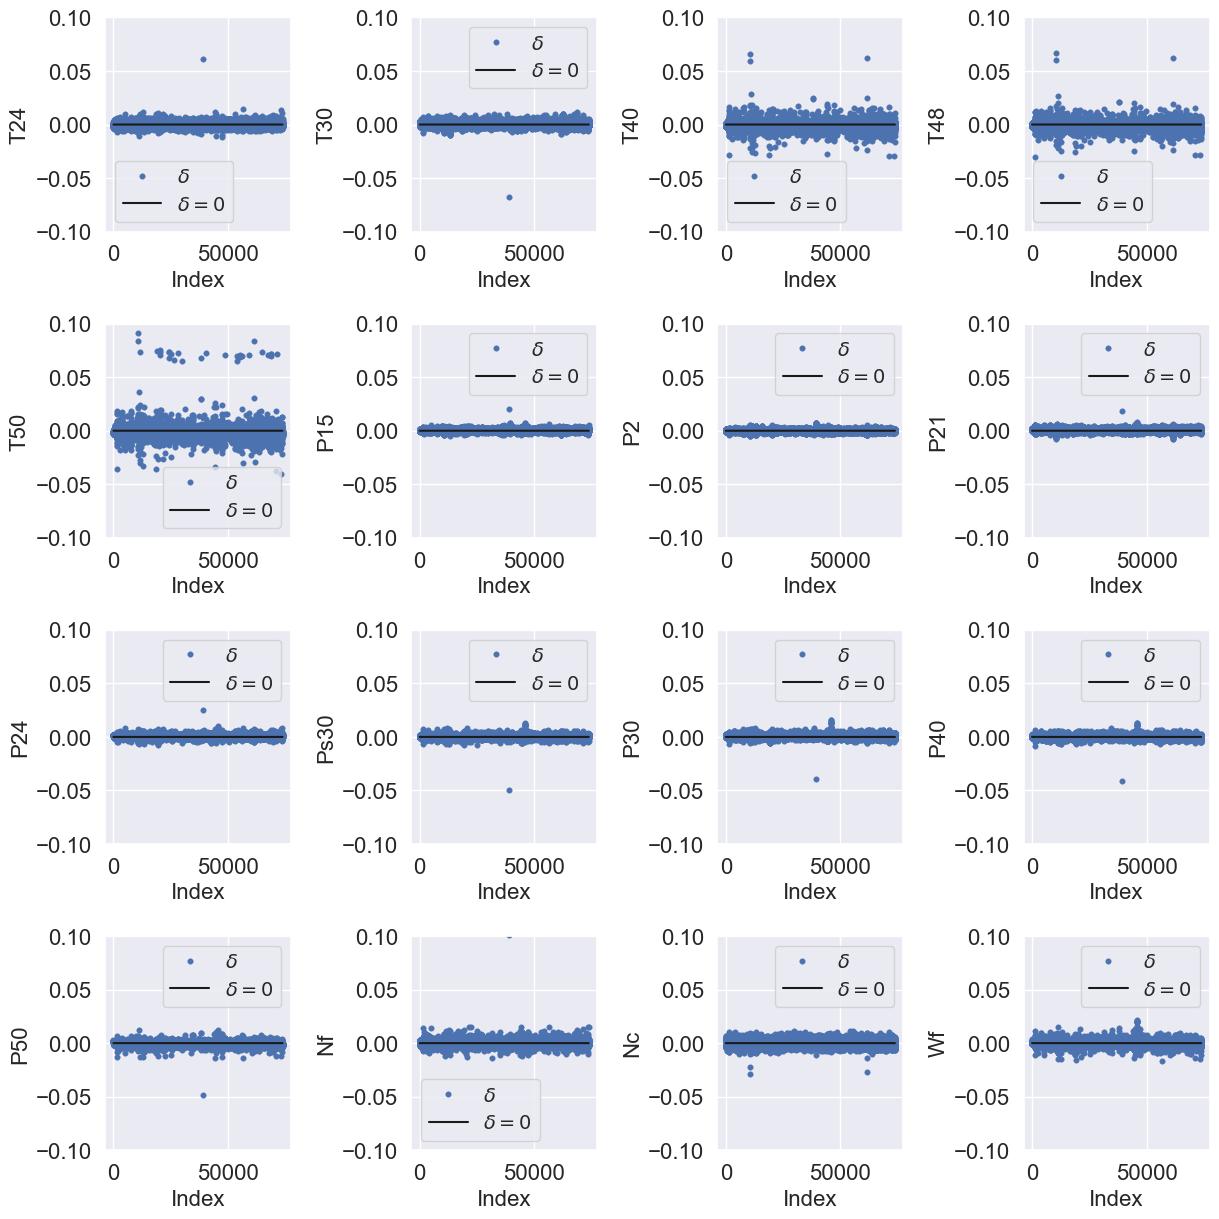

In [29]:
data, data[0] = {}, {}
data[0]['variables'] = Xs_var
print('')
print(data[0]['variables'])

data[0]['label'] = data[0]['variables']
data[0]['legend'] = ['$\delta$', '$\delta=0$']
data[0]['ds_name'] = ['delta', 'zero']
data[0]['color'] = ['C0', 'C1']

# Data to plot
# delta = True - pred
data[0]['delta'] = {}
data[0]['delta']['y'] = delta_lab
data[0]['delta']['x'] = np.arange(data[0]['delta']['y'].shape[0])

# Zero line
data[0]['zero'] = {}
data[0]['zero']['y'] = np.zeros(shape=data[0]['delta']['y'].shape)
data[0]['zero']['x'] = np.arange(data[0]['zero']['y'].shape[0])
data[0]['zero']['marker'] = 'k-'

# Plot limits
y_min = -0.1              # Min y
y_max = 0.1               # Max y

# Plot
plot_variables_iso(data, figsize=12.5, y_min=y_min, y_max=y_max)

**Test dataset**

We also plot the delta for the test dataset as a function of the datapoint index $j$


['T24', 'T30', 'T40', 'T48', 'T50', 'P15', 'P2', 'P21', 'P24', 'Ps30', 'P30', 'P40', 'P50', 'Nf', 'Nc', 'Wf']


<Figure size 640x480 with 0 Axes>

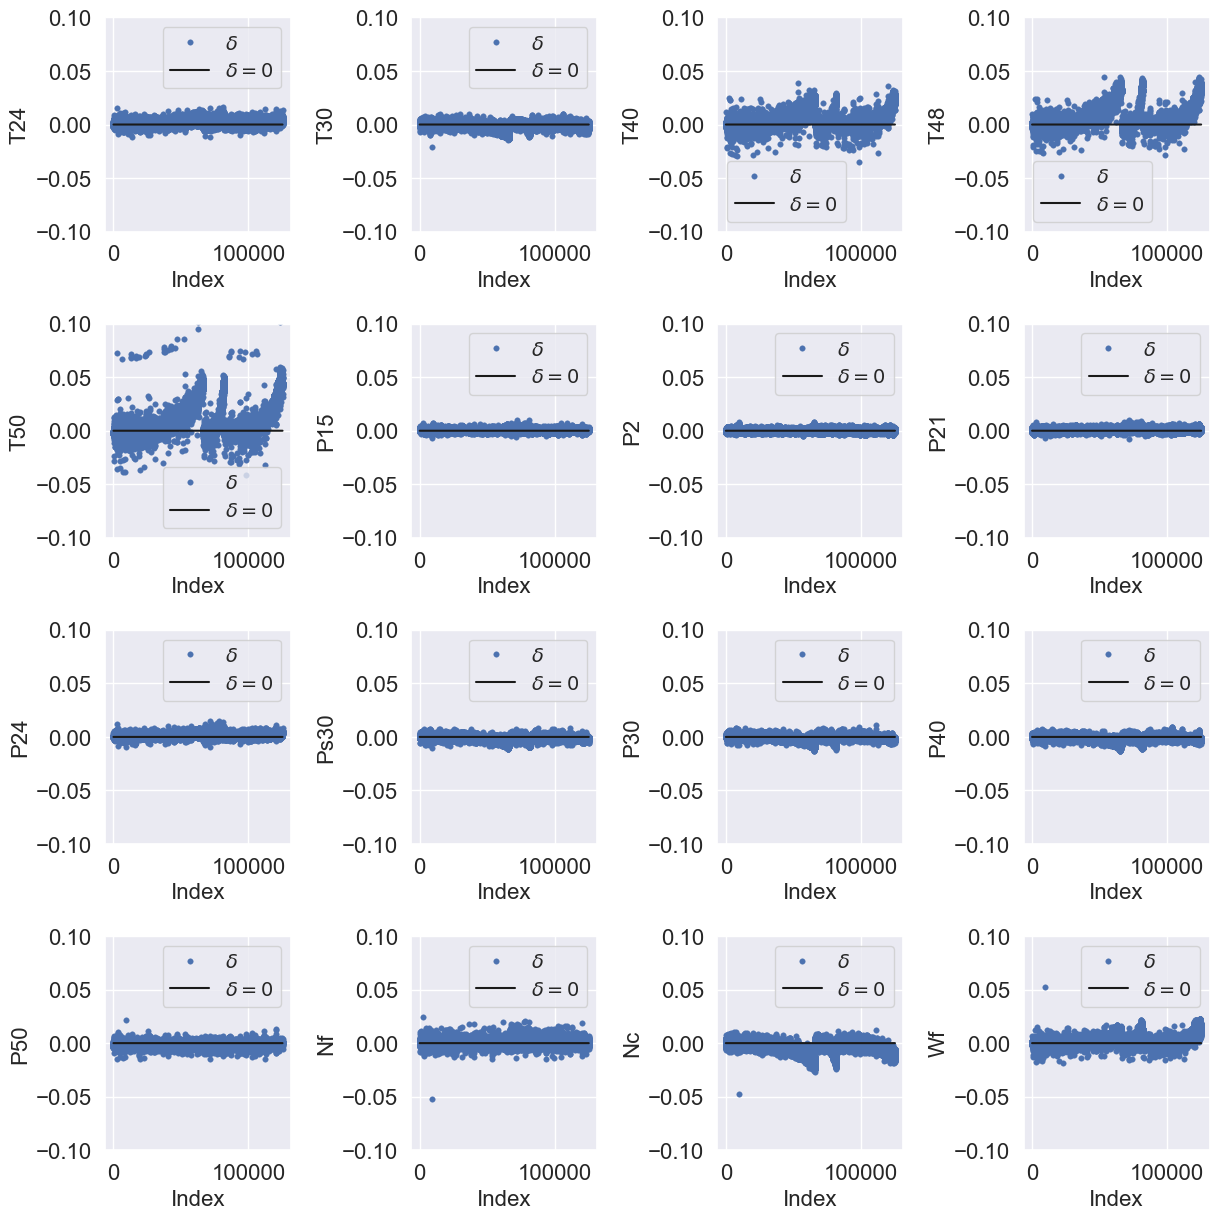

In [30]:
data, data[0] = {}, {}
data[0]['variables'] = Xs_var
print('')
print(data[0]['variables'])

data[0]['label'] = data[0]['variables']
data[0]['legend'] = ['$\delta$', '$\delta=0$']
data[0]['ds_name'] = ['delta', 'zero']
data[0]['color'] = ['C0', 'C1']

# Data to plot
data[0]['delta'] = {}
data[0]['delta']['y'] = delta_test
data[0]['delta']['x'] = np.arange(data[0]['delta']['y'].shape[0])
#data[0]['delta']['units'] = U_test

data[0]['zero'] = {}
data[0]['zero']['y'] = np.zeros(shape=data[0]['delta']['y'].shape)
data[0]['zero']['x'] = np.arange(data[0]['zero']['y'].shape[0])
data[0]['zero']['marker'] = 'k-'

# Plot limits
y_min = -0.1              # Min y
y_max = 0.1             # Max y

# Plot
plot_variables_iso(data, figsize=12.5, y_min=y_min, y_max=y_max)

## Step 3.4:  Identify features with larger deviations on the test set $\mathcal{D}_{T_*}$ 

The system model $\mathcal{D}$ allows the computation of the expected $[\hat{w}^{(t)}, \hat{x}_{s*}^{(t)}]$signal values under the training input conditions (i.e., $w$). The output of the $\mathcal{D}$ i.e., $\hat{x}_{s*}^{(t)}$ will deviate from the input value $x_{s*}$ when the inner relationship of a new data point $x_{s*}^{(j)} \in \{\mathcal{D}_{U},\mathcal{D_{T}}\}$ does not correspond to the one observed in the training set $S_{T}$. Therefore, we compute the absolute deviation that each component of the reconstructed signals has (i.e., $|\delta^{(t)}_k|$) relative to the error observed in the validation dataset $S_V$ (i.e., healthy operation conditions).

\begin{equation} 
  d_I(x_k^{(j)};\nu_k) =  \frac{|\delta_k^{(j)}|}{\nu_k}
\end{equation}

where $\nu$ corresponds to a normalizing threshold given by the 99.9\% percentile of the absolute error of the prediction of $F$ in the validation set $S_{V}$


\begin{equation}
  \nu_k = P_{99.9}\big(\{|\delta_k^{(i)}| \; | \; x_k^{(i)}\in S_V\}\big) % \; \forall
\end{equation}

$d_I(x_k^{(j)};\nu)$ is an unbounded measure of similarity between the signal value predicted by $\mathcal{G}$ and the expected or true signal value.


**Exercise 3.4.1 [10 pts]:** Implement a new function `similarity()` computing the similarity score given the `true`, model prediction `pred` and the residual `delta_ref`. Therefore, the function needs to implement the following steps:   

* Compute the absolute residual $\mid x^{(j)}- \mathbf{\mathcal{D}}(w^{(j)}) \mid$ between the target label $x^{(j)}$ and detection model predictions $\mathbf{\mathcal{D}}(w^{(j)})$.
* Compute the normalizing threshold $\xi$ using the labeled data set $\mathcal{D}_{L}$.

Compute the similarity score on the training, validation and test data. Denote the corresponding new variables as `di_{train, val, test}`.

In [31]:
def similarity(true, pred, delta_ref):
    '''
    This function implements $d_I(x_k^{(j)};\nu)$. This is, the unbounded similary score
    or the absolute deviation that each component of two vertors "true" and 'pred' 
    nomalized to a reference error vector "delta_ref"
    '''
    
    ### START CODE HERE ### 
    # Set-up
    gamma = 1.0

    # Define a detection threshold based on the quantile of the validation set
    abs_delta_ref = np.abs(delta_ref)
    threshold = gamma*np.percentile(abs_delta_ref, 99.9, axis=0)

    # Compute metric
    rel_abs_delta = np.abs(true - pred)/threshold
    
    ### END CODE HERE ### 
    
    return rel_abs_delta

In [32]:
### START CODE HERE ### 
# Compute score
delta_ref = Xs_lab - Xs_hat_lab
di_test = similarity(Xs_test, Xs_hat_test, delta_ref)
di_train = similarity(Xs_train, Xs_hat_train, delta_ref)
di_val = similarity(Xs_val, Xs_hat_val, delta_ref)
### END CODE HERE ###

**Exercise 3.4.2 [5 pts]:** Make use of the auxiliary code provided below and identify the variables with larger residuals on the test set $\mathcal{D}_{T_*}$. 

1. Where is the fault localized according to this residual approach?
2. Plot $ d_I(x_k^{(j)};\nu_k)$ for the test set for the 9 most affected residual features.
3. Does it fit the failure mode of the test units? Justify your answer.

In [33]:
def evaluate_isolation(true, pred, delta_ref):

    # Set-up
    numSignals = 10
        
    # Similarity evaluation
    rel_abs_delta = similarity(true, pred, delta_ref)
    
    # Isolation
    mean_rel_abs_delta = np.mean(rel_abs_delta, axis=0)
    delta_sorted = sorted(mean_rel_abs_delta, reverse = True)[0:numSignals]
    idx_top = np.argsort(mean_rel_abs_delta)[::-1][:numSignals]    

    return delta_sorted, idx_top

def report_isolation(delta_sorted, idx_top, varname):
    isolation = [varname[x] for x in idx_top]
    dict_isolation = {key: value for (key, value) in zip(isolation, delta_sorted)}
    for key in dict_isolation:
        print(key, ' : ', np.round(dict_isolation[key],3))  

In [34]:
### *** START CODE HERE ***
delta_sorted, idx_top = evaluate_isolation(Xs_test, Xs_hat_test, delta_ref)
report_isolation(delta_sorted, idx_top, Xs_var)
### END CODE HERE ###

T48  :  0.621
T50  :  0.52
Nc  :  0.511
T40  :  0.392
T24  :  0.379
Wf  :  0.339
P40  :  0.304
P24  :  0.284
T30  :  0.278
Ps30  :  0.253



['T48', 'T50', 'Nc', 'T40', 'T24', 'Wf', 'P40', 'P24', 'T30']


<Figure size 640x480 with 0 Axes>

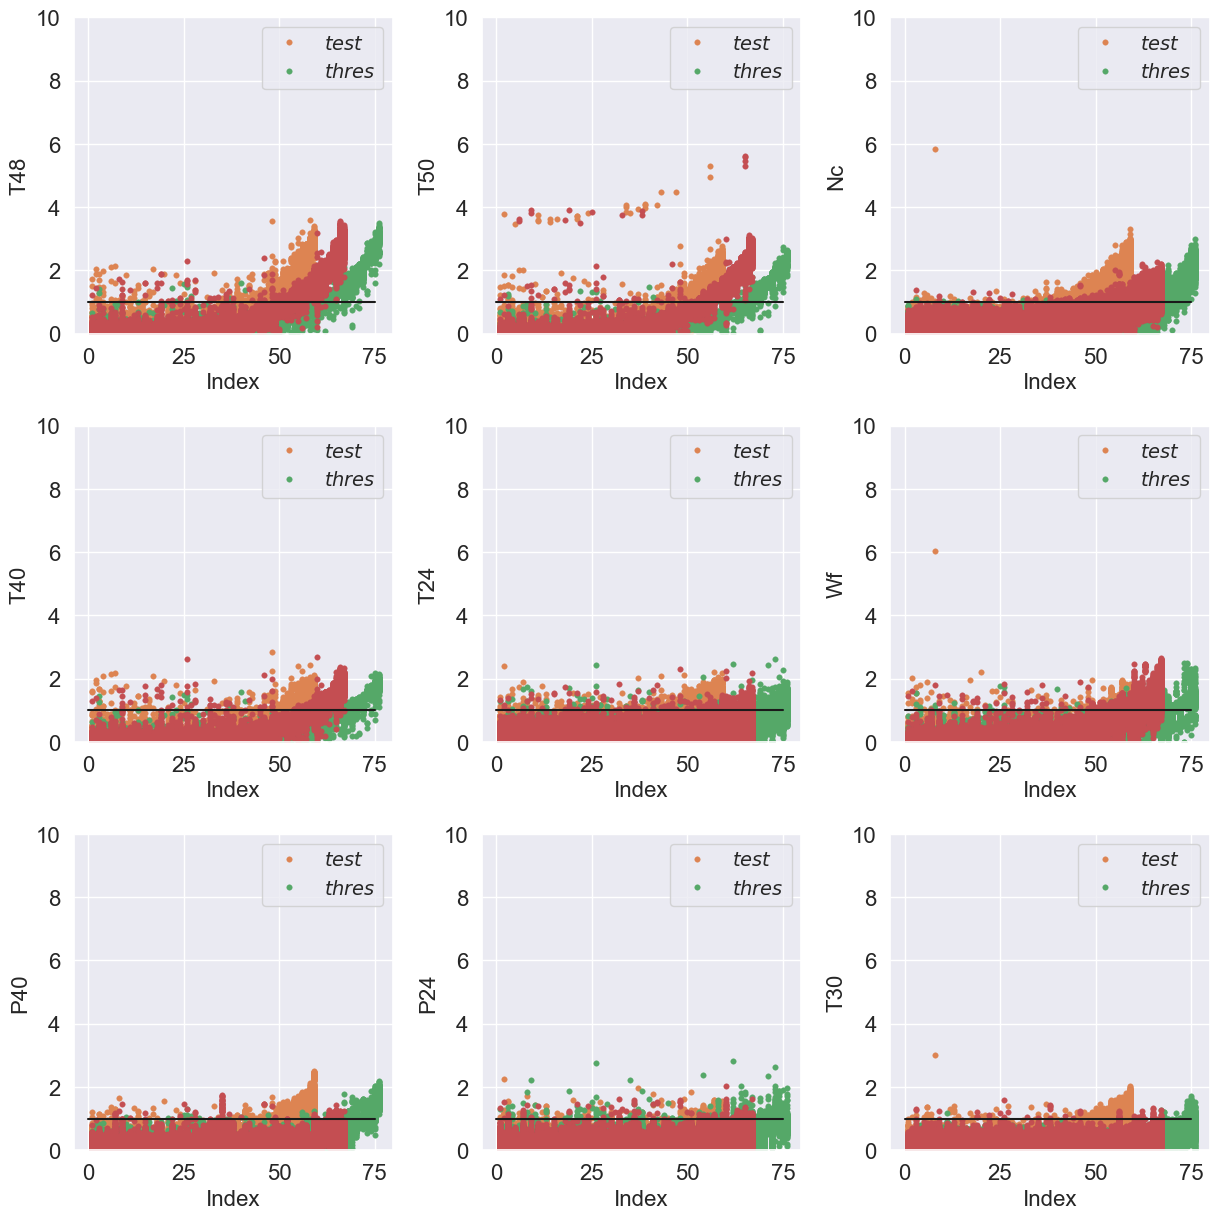

In [35]:
subset = idx_top[0:9]
data, data[0] = {}, {}
data[0]['variables'] = [Xs_var[x] for x in subset]     # Variables names
print('')
print(data[0]['variables'])

data[0]['label'] = data[0]['variables']
data[0]['legend'] = ['$test$', '$thres$']
data[0]['ds_name'] = ['test', 'threshold']
data[0]['option'] = 'score'

# Data to plot
data[0]['test'] = {}
data[0]['test']['y'] = di_test[:,subset] 
data[0]['test']['x'] = np.arange(data[0]['test']['y'].shape[0])
data[0]['test']['x'] = C_test
data[0]['test']['units'] = U_test

thrs_test = np.ones(np.max(C_test)).reshape(-1,1)
data[0]['threshold'] = {}
data[0]['threshold']['y'] = np.repeat(thrs_test, len(subset), axis=1)
data[0]['threshold']['x'] = np.arange(data[0]['threshold']['y'].shape[0])
data[0]['threshold']['marker'] = 'k-'

# Plot limits
y_min = 0.0           # Min y
y_max = 10.0          # Max y

# Plot
plot_variables_iso(data, figsize=12.5, y_min=y_min, y_max=y_max)

It is worth noting that ${d_I}(x_k^{(j)};\nu_k)$ are obtained at each point in time at which a new sample is available. Therefore, unit-specific pointwise estimations can show high variability within a flight cycle. In order to mitigate this effect, we also define the average $d_I$ at cycle $c$ in unit $u$ (i.e., ${d_I}_{u}^{[c]}$), which is defined as follows: 

\begin{align}
	 {d_I}_{u}^{[c]} &= \frac{1}{m_u^{[c]}} \sum_{j=1}^{m_u^{[c]}}  {d_I}_{u}(x_k^{(j)};\nu_k)
\end{align}

where $m_u^{[c]}$ is the length of the flight cycle $c$ for the \textit{u-th} unit, which is formally defined using the indicator function, i.e., $\mathbf{1}\{.\}$, as:

\begin{align}
m_u^{[c]}=\sum_{j=1}^{m_*} \mathbf{1}\{U^{(j)} = u \; \wedge \; C^{(j)}=c\}
\end{align}

We can compute the with the function  `mean_per_cycle()` 

In [36]:
di_c_train = mean_per_cycle(di_train, U_train, C_train)
di_c_val = mean_per_cycle(di_val, U_val, C_val)
di_c_test = mean_per_cycle(di_test, U_test, C_test)


['T48', 'T50', 'Nc', 'T40', 'T24', 'Wf', 'P40', 'P24', 'T30']


<Figure size 640x480 with 0 Axes>

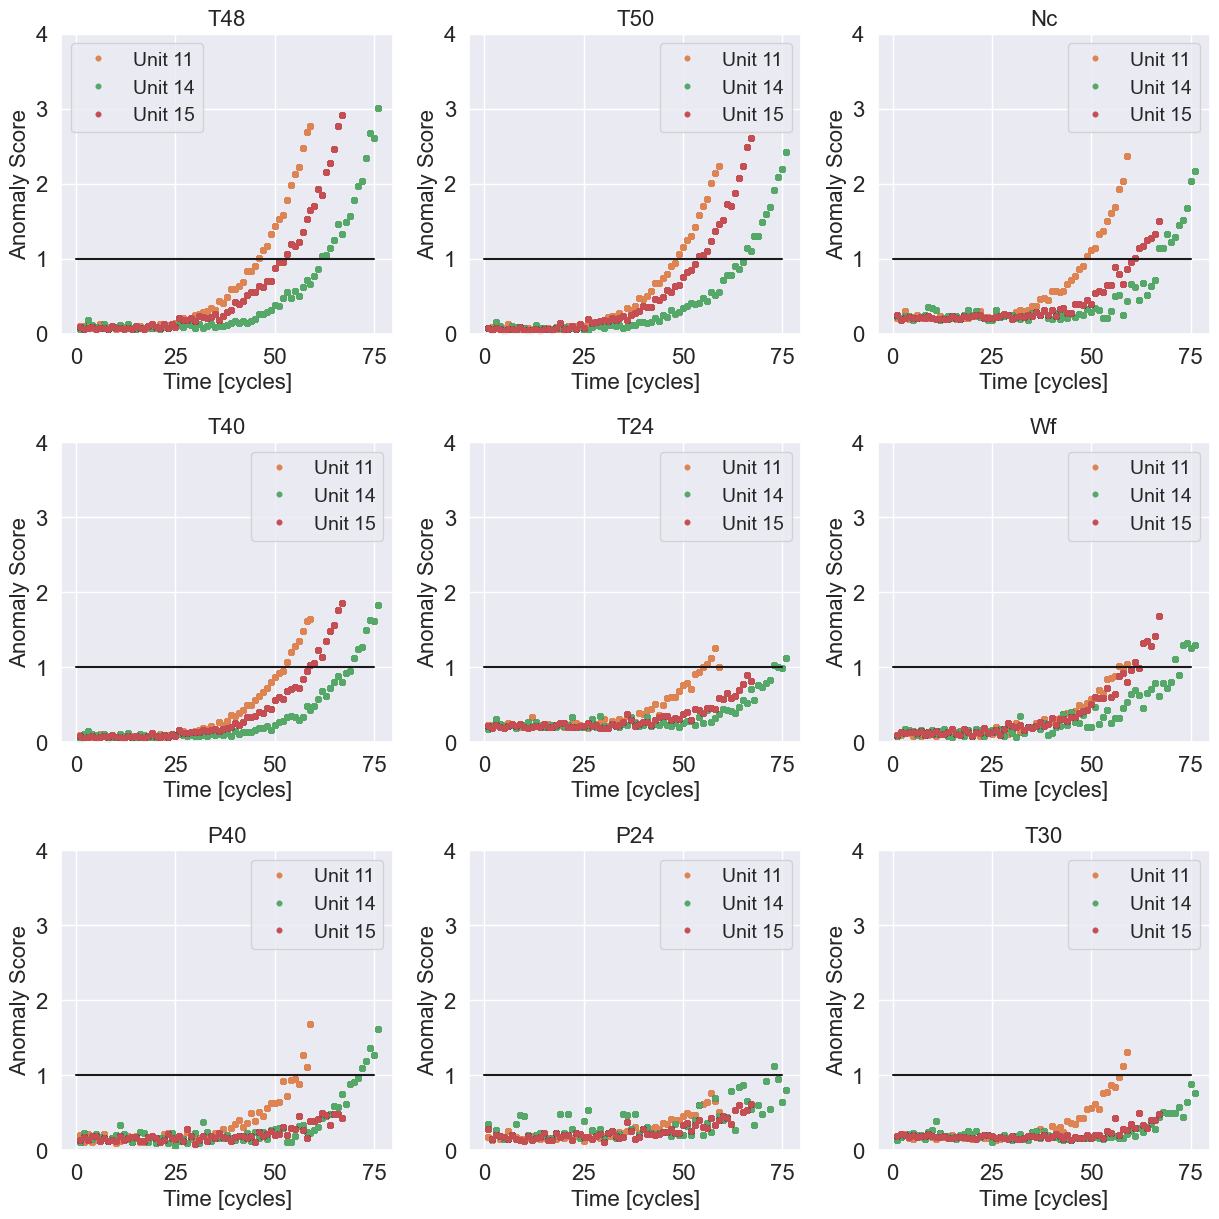

In [37]:
subset = idx_top[0:9]
data, data[0] = {}, {}
data[0]['variables'] = [Xs_var[x] for x in subset]     # Variables names
print('')
print(data[0]['variables'])

data[0]['label'] = data[0]['variables']
data[0]['ds_name'] = ['test', 'threshold']
data[0]['ylabel'] ='score'
data[0]['xlabel'] ='Time [cycles]'

# Data to plot
data[0]['test'] = {}
data[0]['test']['y'] = di_c_test[:,subset] 
data[0]['test']['x'] = C_test
data[0]['test']['units'] = U_test

thrs_test = np.ones(np.max(C_test)).reshape(-1,1)
data[0]['threshold'] = {}
data[0]['threshold']['y'] = np.repeat(thrs_test, len(subset), axis=1)
data[0]['threshold']['x'] = np.arange(data[0]['threshold']['y'].shape[0])
data[0]['threshold']['marker'] = 'k-'

# Plot limits
y_min = 0.0           # Min y
y_max = 4.0          # Max y

# Plot
plot_variables_iso(data, figsize=12.5, y_min=y_min, y_max=y_max)

We can also and compute an alternative metric of dissimilarity defined as follows:

\begin{equation}
  d_{u}^{[c]} =  \frac{|\delta_{u}^{[c]}|}{\nu^{[c]}}
\end{equation}

where $\nu^{[c]}$ corresponds to a normalizing threshold given by the 99.9\% percentile of the absolute error $d^{[c]}$ in the validation set $S_{V}$.

**Exercise 3.4.3 [5 pts]:** Make use of the auxiliary function `mae_per_cycle()` and implement the alternative metric of  dissimilarity $d_{u}^{[c]}$ on the training, validation and test set $\mathcal{D}_{T_*}$. Denote the resulting metric `d_{train, val, test}`.


In [38]:
### START CODE HERE ### 
mae_lab = mae_per_cycle(delta_lab, U_lab, C_lab)
threshold = np.percentile(mae_lab, 99.9, axis=0)

# Training dataset
mae_train = mae_per_cycle(delta_train, U_train, C_train)
d_train = mae_train/threshold

# Validation dataset
mae_val = mae_per_cycle(delta_val, U_val, C_val)
d_val = mae_val/threshold

# Test dataset
mae_test = mae_per_cycle(delta_test, U_test, C_test)
d_test = mae_test/threshold
### END CODE HERE ### 


['T48', 'T50', 'Nc', 'T40', 'T24', 'Wf', 'P40', 'P24', 'T30']


<Figure size 640x480 with 0 Axes>

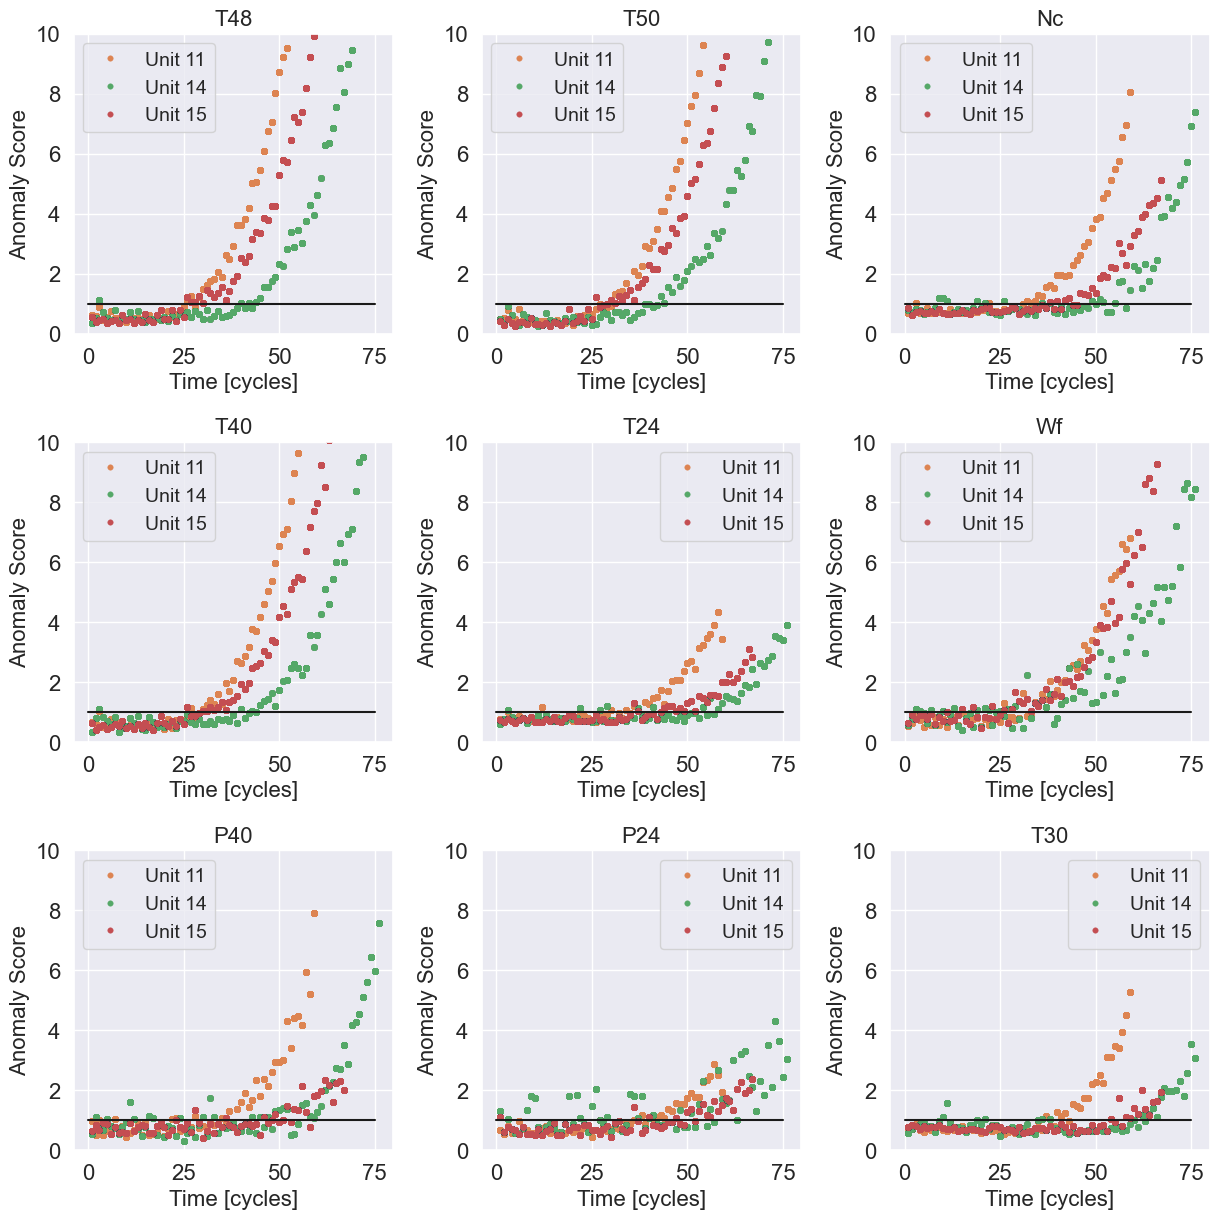

In [39]:
subset = idx_top[0:9]
data, data[0] = {}, {}
data[0]['variables'] = [Xs_var[x] for x in subset]     # Variables names
print('')
print(data[0]['variables'])

data[0]['label'] = data[0]['variables']
data[0]['ds_name'] = ['test', 'threshold']
data[0]['ylabel'] ='score'
data[0]['xlabel'] ='Time [cycles]'

# Data to plot
data[0]['test'] = {}
data[0]['test']['y'] = d_test[:,subset] 
data[0]['test']['x'] = C_test
data[0]['test']['units'] = U_test

thrs_test = np.ones(np.max(C_test)).reshape(-1,1)
data[0]['threshold'] = {}
data[0]['threshold']['y'] = np.repeat(thrs_test, len(subset), axis=1)
data[0]['threshold']['x'] = np.arange(data[0]['threshold']['y'].shape[0])
data[0]['threshold']['marker'] = 'k-'

# Plot limits
y_min = 0.0           # Min y
y_max = 10.0          # Max y

# Plot
plot_variables_iso(data, figsize=12.5, y_min=y_min, y_max=y_max)

## Step 3.5:  Fault detection with an unbounded anomaly score in $\mathcal{D}_{T_*}$ 

We can observe from the figure above that the effect of degradation is notizable at different point in times (i.e., cycles `c`) for each units. Therefore, we might be interested to have an agregated metric indicating an early presence of an anomaly. To do so, we can then compute a similar metric of dissimilarity

\begin{equation}
  s_{u}^{[c]} =  \frac{max(|\delta_{u}^{[c]}|)}{\nu^{[c]}}
\end{equation}

**Exercise 3.5 [5 pts]:** Make use of the auxiliary function `mae_per_cycle()` with the additional argument `option='max'` and implemtent the detection metric of $s_{u}^{[c]}$ on the training validation, and test sets. Denote the resulting metric `s_{train, val, test}`. Plot the resulting $s_{u}^{[c]}$ vs. cycle on the test set $\mathcal{D}_{T_*}$

In [40]:
### START CODE HERE ### 
mae_lab = mae_per_cycle(delta_lab, U_lab, C_lab, option='max')
threshold = np.percentile(mae_lab, 99.9, axis=0)

# Training dataset
mae_train = mae_per_cycle(delta_train, U_train, C_train, option='max')
s_train= mae_train/threshold

# Validation dataset
mae_val = mae_per_cycle(delta_val, U_val, C_val, option='max')
s_val= mae_val/threshold

# Test dataset
mae_test = mae_per_cycle(delta_test, U_test, C_test, option='max')
s_test= mae_test/threshold
### END CODE HERE ### 


['Score']


<Figure size 640x480 with 0 Axes>

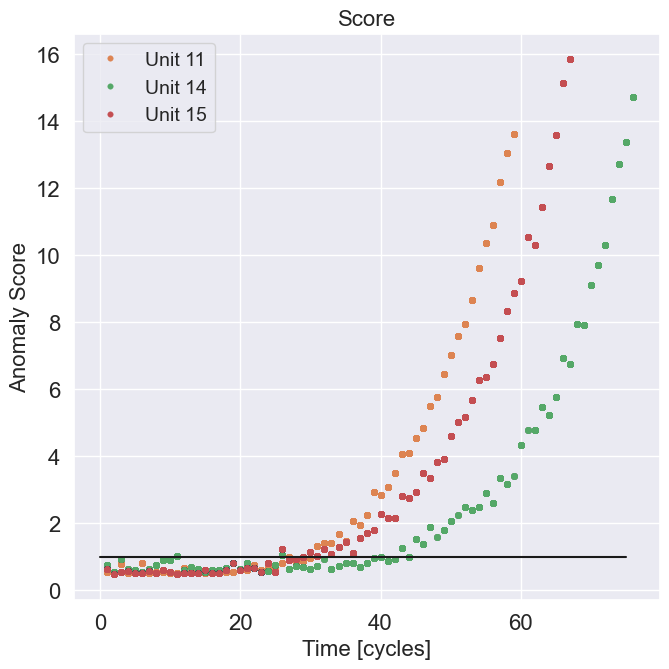

In [41]:
data, data[0] = {}, {}
data[0]['variables'] = ['Score']
print('')
print(data[0]['variables'])

data[0]['label'] = data[0]['variables']
data[0]['ds_name'] = ['test', 'threshold']
data[0]['ylabel'] ='score'
data[0]['xlabel'] ='Time [cycles]'

# Data to plot
data[0]['test'] = {}
data[0]['test']['y'] = s_test
data[0]['test']['x'] = C_test
data[0]['test']['units'] = U_test

data[0]['threshold'] = {}
data[0]['threshold']['y'] = np.ones(np.max(C_test)).reshape(-1,1)
data[0]['threshold']['x'] = np.arange(data[0]['threshold']['y'].shape[0])
data[0]['threshold']['marker'] = 'k-'

# Plot
plot_variables_iso(data, figsize=7)

## Step 3.6:  Implement a fault detection logic declare a faulty state i.e., $\hat{h}_{s}(x^{(j)})=0$ when $s_I(x^{(j)}; \xi) > 1$ 

**Exercise 4.6 [3 pts]:** Compute the estimated health conditing on the test set, i.e., `hs_hat_test` according to the following detection logic:  

\begin{equation}
	\hat{h}_{s}^{[c]} = 
	\begin{cases} 
		1 &   s_{u}^{[c]}  < 1  \\
		0 & \text{otherwise} 
	\end{cases}
\end{equation}

<Figure size 640x480 with 0 Axes>

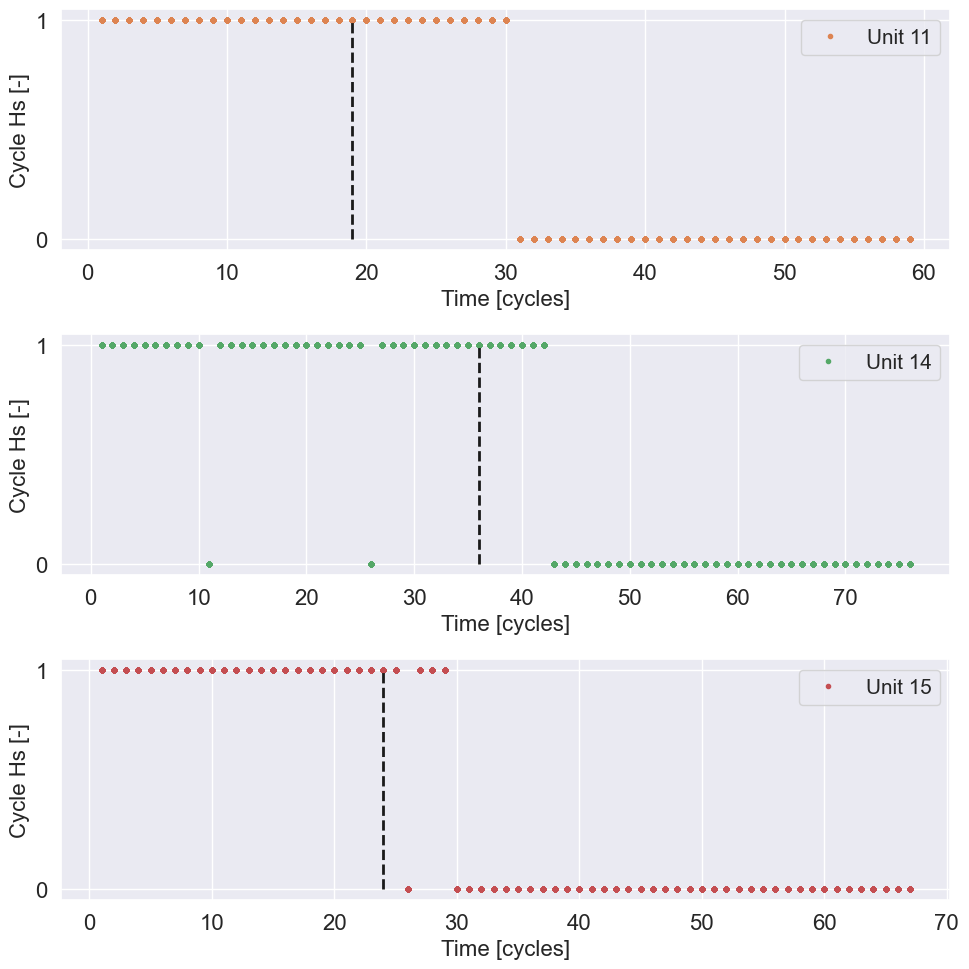

In [42]:
### START CODE HERE ### (≈ 1 lines of code)
h_hat_test = np.where(s_test<1,1,0)
### END CODE HERE ###

data = {}
color_dic = {'11': 'C1', '12': 'C11', '13': 'C12', '14': 'C2', '15': 'C3'}  
fault_onset = {'11':19, '14':36, '15': 24}

for ii, elm in enumerate(np.unique(U_test)):
    # Set up
    data[ii] = {}
    data[ii]['variables'] = ['Score']
    data[ii]['label'] = data[ii]['variables']
    data[ii]['ds_name'] = ['test']
    data[ii]['ylabel'] ='Cycle Hs [-]'
    data[ii]['xlabel'] ='Time [cycles]'
    
    # Data to plot
    mask_u = np.ravel(U_test==elm)
    data[ii]['test'] = {}
    data[ii]['test']['y'] = h_hat_test[mask_u]
    data[ii]['test']['x'] = C_test[mask_u]
    data[ii]['test']['units'] = U_test[mask_u].ravel()
    data[ii]['test']['fault'] = fault_onset[str(elm)]

# Plot
subplot_per_unit(data, color_dic)

# Part 4 [20 pts]: Build prognostics model with detection & dignostics features

In part Part 3 we have computed a new health related feature measuring the anomaly score on a new sample to the healthy i.e., `s_score`. We have also computed the unbounded residuals between the expected system healthy responsed and the measurement `d`. In this part we will make use of these new features and will compute new prognostics models that incorporate this information.  

## Part 4a: Build prognostics model with detection features  $[w, x_s, s] \rightarrow R$

**Exercise 4.1 [10 pts]:** Re-use code from above and train a MLP with the following augmented features  $[w, x_s, s] $. Plot and report the achieved prognostic performance on the test dataset.

In [56]:
# Supervised network
params = {"activ": ['relu'],    # Activation - h1 = ['tanh', 'relu']
          "n_hl": [2],          # Number of hidden layers - h2 = [1, 2, 3]
          "n_cl":  [100],       # Number of neurons per hidden layer (the same for all) - h3 = [50, 100, 150]   
          "n_fc": [50],         # Number of neurons in fully connected layer - h4 = [50, 100, 200]
          "dropout": [0.2],     # Dropout - h5 = [0.1, 0.2, 0.5]
          "batch_size": [64],   # Batch size autoencoder - h6 = [64, 512, 1024]    
          "epochs": [80],       # Epochs - h7 (on demand) 400
          "seed": [229],        # Seed
          "patience": [15]
          }

# Number of runs per NN architecture
n_runs = 1


Simulation: W_Xs_s-R_h_0_run_0
Model: "supervised"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 21)]              0         
                                                                 
 dense (Dense)               (None, 100)               2200      
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 50)                5050      
                                                                 
 dense_2 (Dense)             (None, 1)                 51        
                                                                 
Total params: 7,301
Trainable params: 7,301
Non-trainable params: 0
_________________________________________________________________
Epoch 1/80
3409/3409 [

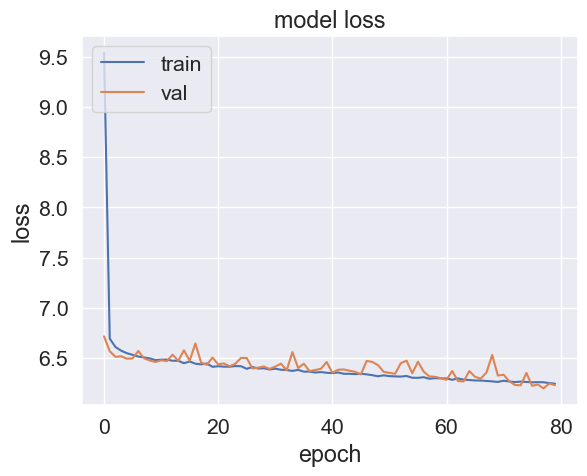

Saved supervised model to disk
3918/3918 [==============================] - 5s 1ms/step

  activ  n_hl  n_cl  n_fc  dropout  batch_size  epochs  seed  patience  run     input  RMSE-Ts  RMSE-Tr  Time[min]
0  relu     2   100    50      0.2          64      80   229        15    0  W_Xs_s-R    6.858    5.893       9.09


In [57]:
if simSel['Part4_a']:
    # Set-up
    ROOT_PATH_4a = ROOT_PATH + 'models/00-SL-Part4a-MLP'
    MODEL_PATH_4a = ROOT_PATH_4a  + '/DS02_' + strftime("%Y-%m-%d", gmtime()) + '/'
    if not os.path.exists(MODEL_PATH_4a):
        os.makedirs(MODEL_PATH_4a)
        
    # Simulation config.
    input_s = 'W_Xs_s'      
    target_s = 'R'      

    # Inputs
    X_train = np.concatenate((W_train, Xs_train, s_train), axis=-1)
    X_val = np.concatenate((W_val, Xs_val, s_val), axis=-1)
    X_test = np.concatenate((W_test, Xs_test, s_test), axis=-1)     
    
    # Outputs
    Y_train = R_train
    Y_val = R_val
    Y_test = R_test

    # Model tag    
    varInput = input_s + '-' + target_s

    # Fit model
    log_Y_hat_train, log_Y_hat_test, df, log_loss_val, log_label_4a = grid_search(MODEL_PATH_4a, 
                                                                      X_train, Y_train, 
                                                                      X_val, Y_val,
                                                                      X_test, Y_test,
                                                                      params, n_runs, varInput, generate=True)

**Plot RUL predictions**

In [ ]:
if simSel['Part4_a']:
    # Evaluate RUL performance
    log_loss_val = np.array(log_loss_val)
    mask = np.ravel(log_loss_val==min(log_loss_val))
    label_4a = list(itertools.compress(log_label_4a, mask))[0]
    baseline_model = tf.keras.models.load_model(MODEL_PATH_4a + 'model_' + str(label_4a) + '.h5')
    Y_hat_train_4a = baseline_model.predict(x=X_train)
    Y_hat_test_4a = baseline_model.predict(x=X_test)

    print('')
    print('Data-driven: ' + varInput)
    print('RMSE Test:', np.round(np.sqrt(np.mean((Y_hat_test_4a - Y_test)**2)),3))

In [ ]:
# True and predict vs time - Test Per engine
unit_sel = [11, 14, 15]

# Plot rul
plot_predicted_true_rul([Y_hat_test_4a], unit_sel, U_test, C_test, Y_test)

## Part 4b: Build prognostics model with diagnostic features  $[w, x_s, d_i] \rightarrow R$

**Exercise 4.2 [10 pts]:** Re-use code from above and train a MLP with the following augmented features  $[w, x_s, d_i] $. Plot and report the achieved prognostic performance on the test dataset.

In [58]:
# Supervised network
params = {"activ": ['relu'],    # Activation - h1 = ['tanh', 'relu']
          "n_hl": [3],          # Number of hidden layers - h2 = [1, 2, 3]
          "n_cl":  [100],       # Number of neurons per hidden layer (the same for all) - h3 = [50, 100, 150]   
          "n_fc": [50],         # Number of neurons in fully connected layer - h4 = [50, 100, 200]
          "dropout": [0.2],     # Dropout - h5 = [0.1, 0.2, 0.5]
          "batch_size": [64],   # Batch size autoencoder - h6 = [64, 512, 1024]    
          "epochs": [100],       # Epochs - h7 (on demand) 400
          "seed": [229],        # Seed
          "patience": [15]
          }

# Number of runs per NN architecture
n_runs = 1


Simulation: W_Xs_d-R_h_0_run_0
Model: "supervised"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 36)]              0         
                                                                 
 dense (Dense)               (None, 100)               3700      
                                                                 
 dense_1 (Dense)             (None, 100)               10100     
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_2 (Dense)             (None, 50)                5050      
                                                                 
 dense_3 (Dense)             (None, 1)                 51        
                                                                 
Total params: 18,901
Tra

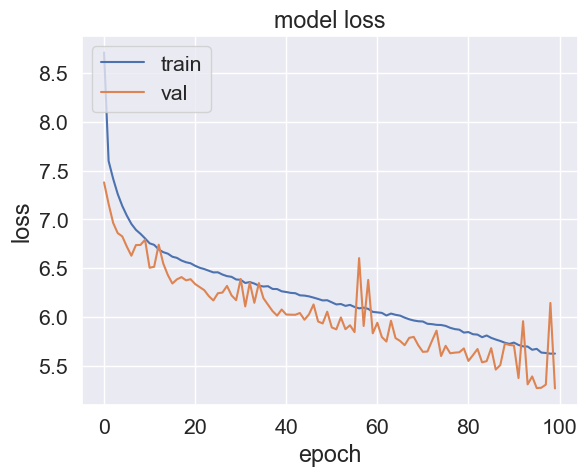

Saved supervised model to disk
3918/3918 [==============================] - 4s 1ms/step

  activ  n_hl  n_cl  n_fc  dropout  batch_size  epochs  seed  patience  run     input  RMSE-Ts  RMSE-Tr  Time[min]
0  relu     3   100    50      0.2          64     100   229        15    0  W_Xs_d-R    6.727    5.118      14.99


In [59]:
if simSel['Part4_b']:
    # Set-up
    ROOT_PATH_4b = ROOT_PATH + 'models/00-SL-Part4b-MLP'
    MODEL_PATH_4b = ROOT_PATH_4b  + '/DS02_' + strftime("%Y-%m-%d", gmtime()) + '/'
    if not os.path.exists(MODEL_PATH_4b):
        os.makedirs(MODEL_PATH_4b)
        
    # Simulation config.
    input_s = 'W_Xs_d'      
    target_s = 'R'      

    # Inputs
    X_train = np.concatenate((W_train, Xs_train, di_train), axis=-1)
    X_val = np.concatenate((W_val, Xs_val, di_val), axis=-1)
    X_test = np.concatenate((W_test, Xs_test, di_test), axis=-1)    

    # Outputs
    Y_train = R_train
    Y_val = R_val
    Y_test = R_test

    # Model tag    
    varInput = input_s + '-' + target_s

    # Fit model
    log_Y_hat_train, log_Y_hat_test, df, log_loss_val, log_label_4b = grid_search(MODEL_PATH_4b, 
                                                                      X_train, Y_train, 
                                                                      X_val, Y_val,
                                                                      X_test, Y_test,
                                                                      params, n_runs, varInput, generate=True)

**Plot RUL predictions**

In [60]:
if simSel['Part4_b']:
    # Evaluate RUL performance
    log_loss_val = np.array(log_loss_val)
    mask = np.ravel(log_loss_val==min(log_loss_val))
    label_4b = list(itertools.compress(log_label_4b, mask))[0]
    baseline_model = tf.keras.models.load_model(MODEL_PATH_4b + 'model_' + str(label_4b) + '.h5')
    Y_hat_train_4b = baseline_model.predict(x=X_train)
    Y_hat_test_4b = baseline_model.predict(x=X_test)

    print('')
    print('Data-driven: ' + varInput)
    print('RMSE Test:', np.round(np.sqrt(np.mean((Y_hat_test_4b - Y_test)**2)),3))

3918/3918 [==============================] - 5s 1ms/step

Data-driven: W_Xs_d-R
RMSE Test: 6.727


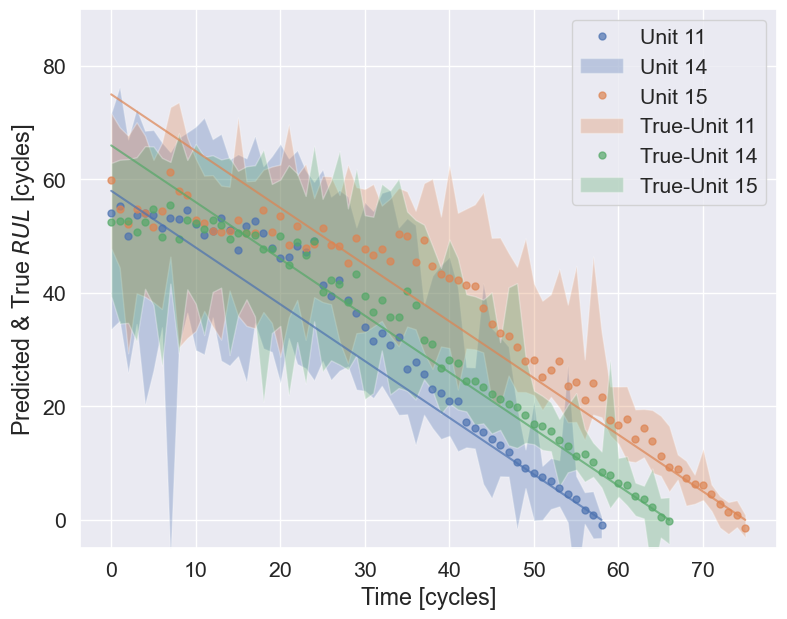

In [61]:
# True and predict vs time - Test Per engine
unit_sel = [11, 14, 15]
log_y_hat_test = [Y_hat_test_4b]

# Plot rul
plot_predicted_true_rul(log_y_hat_test, unit_sel, U_test, C_test, Y_test)

# Part 5 [20 pts]: Summary 

Compare the performance achieved with the three prognostics method covered in this case study, i.e., Part 2, Part 5a, and Part 5b.

1. Which model achieves better performance? Why?. Provide an overview table summarising the RUL performance.


| \# | Model          | RMSE                    | Units    |
|----|----------------|-------------------------|----------|
| 1  | Part 2         |                         | [cycles] |
| 2  | Part 4 a       |                         | [cycles] |
| 3  | Part 4 b       |                         | [cycles] |

2. Which model do you think is more suitable for an application in the field? Why?
3. Analysis of best performing model:
    * Does the RUL performance improves with time? Is this a desirable property? 
    * Does the model tend to overestimate or underestimate RUL? 
    * Is the prediction accuracy the same for all the units? Do you have a possible explanation for this behavior? 

## References
1. Frederick, D.K.; Decastro, J.A.; Litt, J.S. User’s Guide for the Commercial Modular Aero-Propulsion System332
Simulation (C-MAPSS). Technical report, NASA, 2007
2. Ryan May, Jeffrey Csank, Thomas Lavelle, Jonathan Litt, and Ten-Huei Guo. A high-fidelity
simulation of a generic commercial aircraft engine and controller. In 46th AIAA/ASME/SAE/ASEE
Joint Propulsion Conference & Exhibit, page 6630, 2010
3. Manuel Arias Chao, Chetan Kulkarni, Kai Goebel, and Olga Fink. Aircraft Engine Run-to-Failure
Dataset under Real Flight Conditions for Prognostics and Diagnostics. Data, 6(1):5, 2021


## Closing
Congratulations! You are done. I hope you has enjoyed working in this case study!